---

# Model pipeline

---

This notebook should:
 * load data
 * prepare data (column selection, outlier, TrainTestSplit, Standardize)
 * use expanding window crossvalidation
 * store the results for later comparison
 * create control plots
 * Run different models executed via a function.

---



#### setup

In [1]:
# import modules
# basic
import pandas as pd
import numpy as np
import datetime as dt

# SQL
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine

# sklearn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Stationary Tests
from statsmodels.tsa.stattools import adfuller,kpss

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

NSEED = 42

In [2]:
# set graphic parameters to have unified plot appearance
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': 'white', 'grid.color': '.8'}
)
NF_ORANGE = '#ff5a36'
NF_BLUE = '#163251'
cmaps_hex = ['#193251','#FF5A36','#696969', '#7589A2','#FF5A36', '#DB6668']
sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 300

---

#### load data

In [3]:
# Load environment variables from .env file
load_dotenv()

# Get database connection parameters from environment variables
db_name = os.getenv('DB_NAME')
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')

# Create the database URL
db_url = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"

# Create an engine
engine = create_engine(db_url)

# Define your query -> set your table name here
query = 'SELECT * FROM "03_gold"."master_data"'

# Execute the query and load the data into a pandas DataFrame
df_modelling = pd.read_sql(query, engine)

# Display the DataFrame
print(df_modelling.head())

                  timestamp   w_force     w_direc  diff_rad  glob_rad    sun   
0 2018-10-01 00:00:00+00:00  2.713324  240.615421      0.00  0.000000  0.000  \
1 2018-10-01 01:00:00+00:00  2.941578  247.279693      0.00  0.000000  0.000   
2 2018-10-01 02:00:00+00:00  2.848997  253.527299      0.00  0.000000  0.000   
3 2018-10-01 03:00:00+00:00  3.164750  266.024904      0.00  0.000000  0.000   
4 2018-10-01 04:00:00+00:00  3.213837  276.439176      3.75  4.666667  3.625   

       zenith      temp      humid  germany_luxembourg_eur_mwh  ...   
0  122.675417  8.415445  84.180795                       51.41  ...  \
1  115.099167  8.111494  84.637452                       47.38  ...   
2  106.416667  7.915876  84.802443                       47.59  ...   
3   97.163750  7.945259  84.300766                       51.61  ...   
4   87.776667  7.903807  83.965757                       69.13  ...   

   nuclear_[mwh]_generation  lignite_[mwh]_generation   
0                   7927.00        

---

#### outlier treatment - if necessary

In [4]:
################ OUTLIER TREATMENT #######################
# Replace outliers with NAs
df_modelling.loc[df_modelling['germany_luxembourg_eur_mwh'] < -200, 'germany_luxembourg_eur_mwh'] = np.nan

# Replace NAs by imputation
df_modelling['germany_luxembourg_eur_mwh'] = df_modelling['germany_luxembourg_eur_mwh'].interpolate()

---

#### create lagged price feature

In [5]:
# Create lag feature for the same hour on the previous day
df_modelling['price_lag24'] = df_modelling['germany_luxembourg_eur_mwh'].shift(24)

---

#### drop unused prices and other columns

In [6]:
# drop unused prices and columns if necessary
df_modelling = df_modelling.drop(columns=['avg_de_lu_neighbours_eur_mwh', 'belgium_eur_mwh', 'denmark_1_eur_mwh', 'denmark_2_eur_mwh',
        'france_eur_mwh', 'netherlands_eur_mwh', 'norway_2_eur_mwh', 'austria_eur_mwh', 'poland_eur_mwh', 'sweden_4_eur_mwh', 'switzerland_eur_mwh',
        'czech_republic_eur_mwh', 'de_at_lu_eur_mwh', 'northern_italy_eur_mwh', 'slovenia_eur_mwh', 'hungary_eur_mwh'])

---

#### change datetime to numeric (necessary for linear models)

In [7]:
# Change datetime to numeric
df_modelling['timestamp'] = pd.to_datetime(df_modelling['timestamp'])
df_modelling['timestamp']=df_modelling['timestamp'].map(dt.datetime.toordinal)

---

#### drop missing values introduced to lagged features 
 * maybe add rolling variance and mean before?

In [8]:
# Drop missing values introduced due to the lag
df_modelling.dropna(inplace=True)

---
---
#### Define target and features

In [9]:
# Define the target and the feature (lagged values)
X = df_modelling.drop(columns=['germany_luxembourg_eur_mwh'])
y = df_modelling['germany_luxembourg_eur_mwh']

---
#### create splits for expanding window

In [10]:
# create splits for expanding window crossvalidation
# Parameters
n_splits = 23 # our data has 23 quarters = (len(X) / 2190)
train_increment = 2190  # Number of hours in a quarter year
test_size = 72 # we currently want to predict for 72 hours. Can be adjusted.

class CustomTimeSeriesSplit:
    def __init__(self, n_splits, train_increment, test_size):
        self.n_splits = n_splits
        self.train_increment = train_increment
        self.test_size = test_size

    def split(self, X):
        n_samples = len(X)
        indices = np.arange(n_samples)
        splits = []
        
        for i in range(self.n_splits):
            train_end = (i + 1) * self.train_increment
            test_end = train_end + self.test_size
            
            if test_end > n_samples:
                break

            train_index = indices[:train_end]
            test_index = indices[train_end:test_end]
            splits.append((train_index, test_index))
        
        return splits
    

# Get the custom splits
custom_splitter = CustomTimeSeriesSplit(n_splits=n_splits, train_increment=train_increment, test_size=test_size)
splits = custom_splitter.split(X)

---
#### Create model function

In [23]:
def evaluate_time_series_model(X, y, model_class, model_params=None, n_splits=n_splits):
    """
    Evaluate a time series model with time series cross-validation.

    Parameters:
    - X: pd.DataFrame, feature matrix
    - y: pd.Series, target variable
    - model_class: Class, model class to be used (e.g., LinearRegression)
    - model_params: dict, hyperparameters for the model (default is None)
    - n_splits: int, number of splits for time series cross-validation

    Returns:
    - mse_scores: list of MSE scores for each split
    - average_mse: average MSE across all splits
    - mse_score_sum: DataFrame containing MSE scores for each split and type (Train/Test)
    - plot_data: list of dictionaries containing data for plotting
    """
    if model_params is None:
        model_params = {}

    mse_scores = []
    mse_score_graph = []
    plot_data = []

    for i, (train_index, test_index) in enumerate(splits):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # For non-ARIMA models
        if model_class != ARIMA:
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            model = model_class(**model_params)
            model.fit(X_train_scaled, y_train)
            
            y_pred_train = model.predict(X_train_scaled)
            y_pred_test = model.predict(X_test_scaled)
        
        # For ARIMA models
        else:
            model = ARIMA(y_train, **model_params)
            model_fit = model.fit()
            
            y_pred_train = model_fit.fittedvalues
            y_pred_test = model_fit.forecast(steps=len(y_test))
        
        mse_train = mean_squared_error(y_train, y_pred_train)
        mse_test = mean_squared_error(y_test, y_pred_test)
        
        mse_scores.append(mse_test)
        
        print(f"Split {i+1}:")
        print(f"MSE (train): {mse_train}, MSE (test): {mse_test}")
        
        # Prepare data for seaborn
        mse_comparison = pd.DataFrame({
            'Type': ['Train', 'Test'],
            'MSE': [mse_train, mse_test],
            'split': [i+1, i+1]
        })
        mse_score_graph.append(mse_comparison)
        
        # Store data for plotting later
        plot_data.append({
            'split': i+1,
            'y_train': y_train,
            'y_pred_train': y_pred_train,
            'y_test': y_test,
            'y_pred_test': y_pred_test
        })

    # Optional: Average MSE across all splits for overall evaluation
    average_mse = sum(mse_scores) / len(mse_scores)
    print(f"Average Test MSE across all splits: {average_mse}")

    mse_score_sum = pd.concat(mse_score_graph, axis=0)
    mse_score_sum['split'] = mse_score_sum['split'].astype(int)

    return mse_scores, average_mse, mse_score_sum, plot_data

---

#### create plot function

In [12]:
def plot_time_series(plot_data, mse_score_sum, model_name = '', only_bar = True):
    """
    Plot the time series data stored in plot_data.

    Parameters:
    - plot_data: list of dictionaries containing data for plotting
    - mse_score_sum: DataFrame containing MSE scores for each split and type (Train/Test)
    - only_bar: if False, Time Series Plots will created for each split. Default = True.
    """

    if only_bar == False:
        for data in plot_data:
            split = data['split']
            y_train = data['y_train']
            y_pred_train = data['y_pred_train']
            y_test = data['y_test']
            y_pred_test = data['y_pred_test']

            # Plotting Full Time Series
            plt.figure()
            sns.lineplot(x=y_train.index, y=y_train, label='Actual train')
            sns.lineplot(x=y_train.index, y=y_pred_train, label='Predicted train', linestyle='--')
            sns.lineplot(x=y_test.index, y=y_test, label='Actual test')
            sns.lineplot(x=y_test.index, y=y_pred_test, label='Predicted test', linestyle='--')
            plt.title(f'Actual vs Predicted for Split {split}')
            plt.xlabel('Time')
            plt.ylabel('Target')
            plt.legend()
            plt.show()
            
            # Plotting Zoomed Time Series
            plt.figure()
            sns.lineplot(x=y_train.index[-168:], y=y_train[-168:], label='Actual train')
            sns.lineplot(x=y_train.index[-168:], y=y_pred_train[-168:], label='Predicted train', linestyle='--')
            sns.lineplot(x=y_test.index, y=y_test, label='Actual test')
            sns.lineplot(x=y_test.index, y=y_pred_test, label='Predicted test', linestyle='--')
            plt.title(f'Zoomed: Actual vs Predicted for Split {split}')
            plt.xlabel('Time')
            plt.ylabel('Target')
            plt.legend()
            plt.show()

    # Plot using seaborn
    if model_name != '':
        model_name = f'{model_name}: '
    plt.figure()
    sns.barplot(x='split', y='MSE', hue='Type', data=mse_score_sum)
    plt.title(f'{model_name}Comparison of MSE for Training and Test Sets')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('Split')
    plt.show()

---
---
---
## Models

--- 
#### Linear Model

Split 1:
MSE (train): 49.55860129432144, MSE (test): 199.87240922949613
Split 2:
MSE (train): 52.06408727767478, MSE (test): 49.799444332758846
Split 3:
MSE (train): 70.1773302780467, MSE (test): 9.114341871582342
Split 4:
MSE (train): 61.684060877419256, MSE (test): 55.70141528009916
Split 5:
MSE (train): 58.38437809725677, MSE (test): 76.0884539176754
Split 6:
MSE (train): 59.11967473056453, MSE (test): 16.349672501577587
Split 7:
MSE (train): 58.41849183593656, MSE (test): 145.26004088670487
Split 8:
MSE (train): 67.55681560558563, MSE (test): 83.32232845396821
Split 9:
MSE (train): 68.49344319737753, MSE (test): 151.33231956338668
Split 10:
MSE (train): 71.36669861089459, MSE (test): 167.81175111709211
Split 11:
MSE (train): 92.39786909269776, MSE (test): 427.0563992317852
Split 12:
MSE (train): 131.59273617113845, MSE (test): 2464.443460772947
Split 13:
MSE (train): 497.8178138370976, MSE (test): 1884.395126773562
Split 14:
MSE (train): 732.1210957472156, MSE (test): 1816.54919687

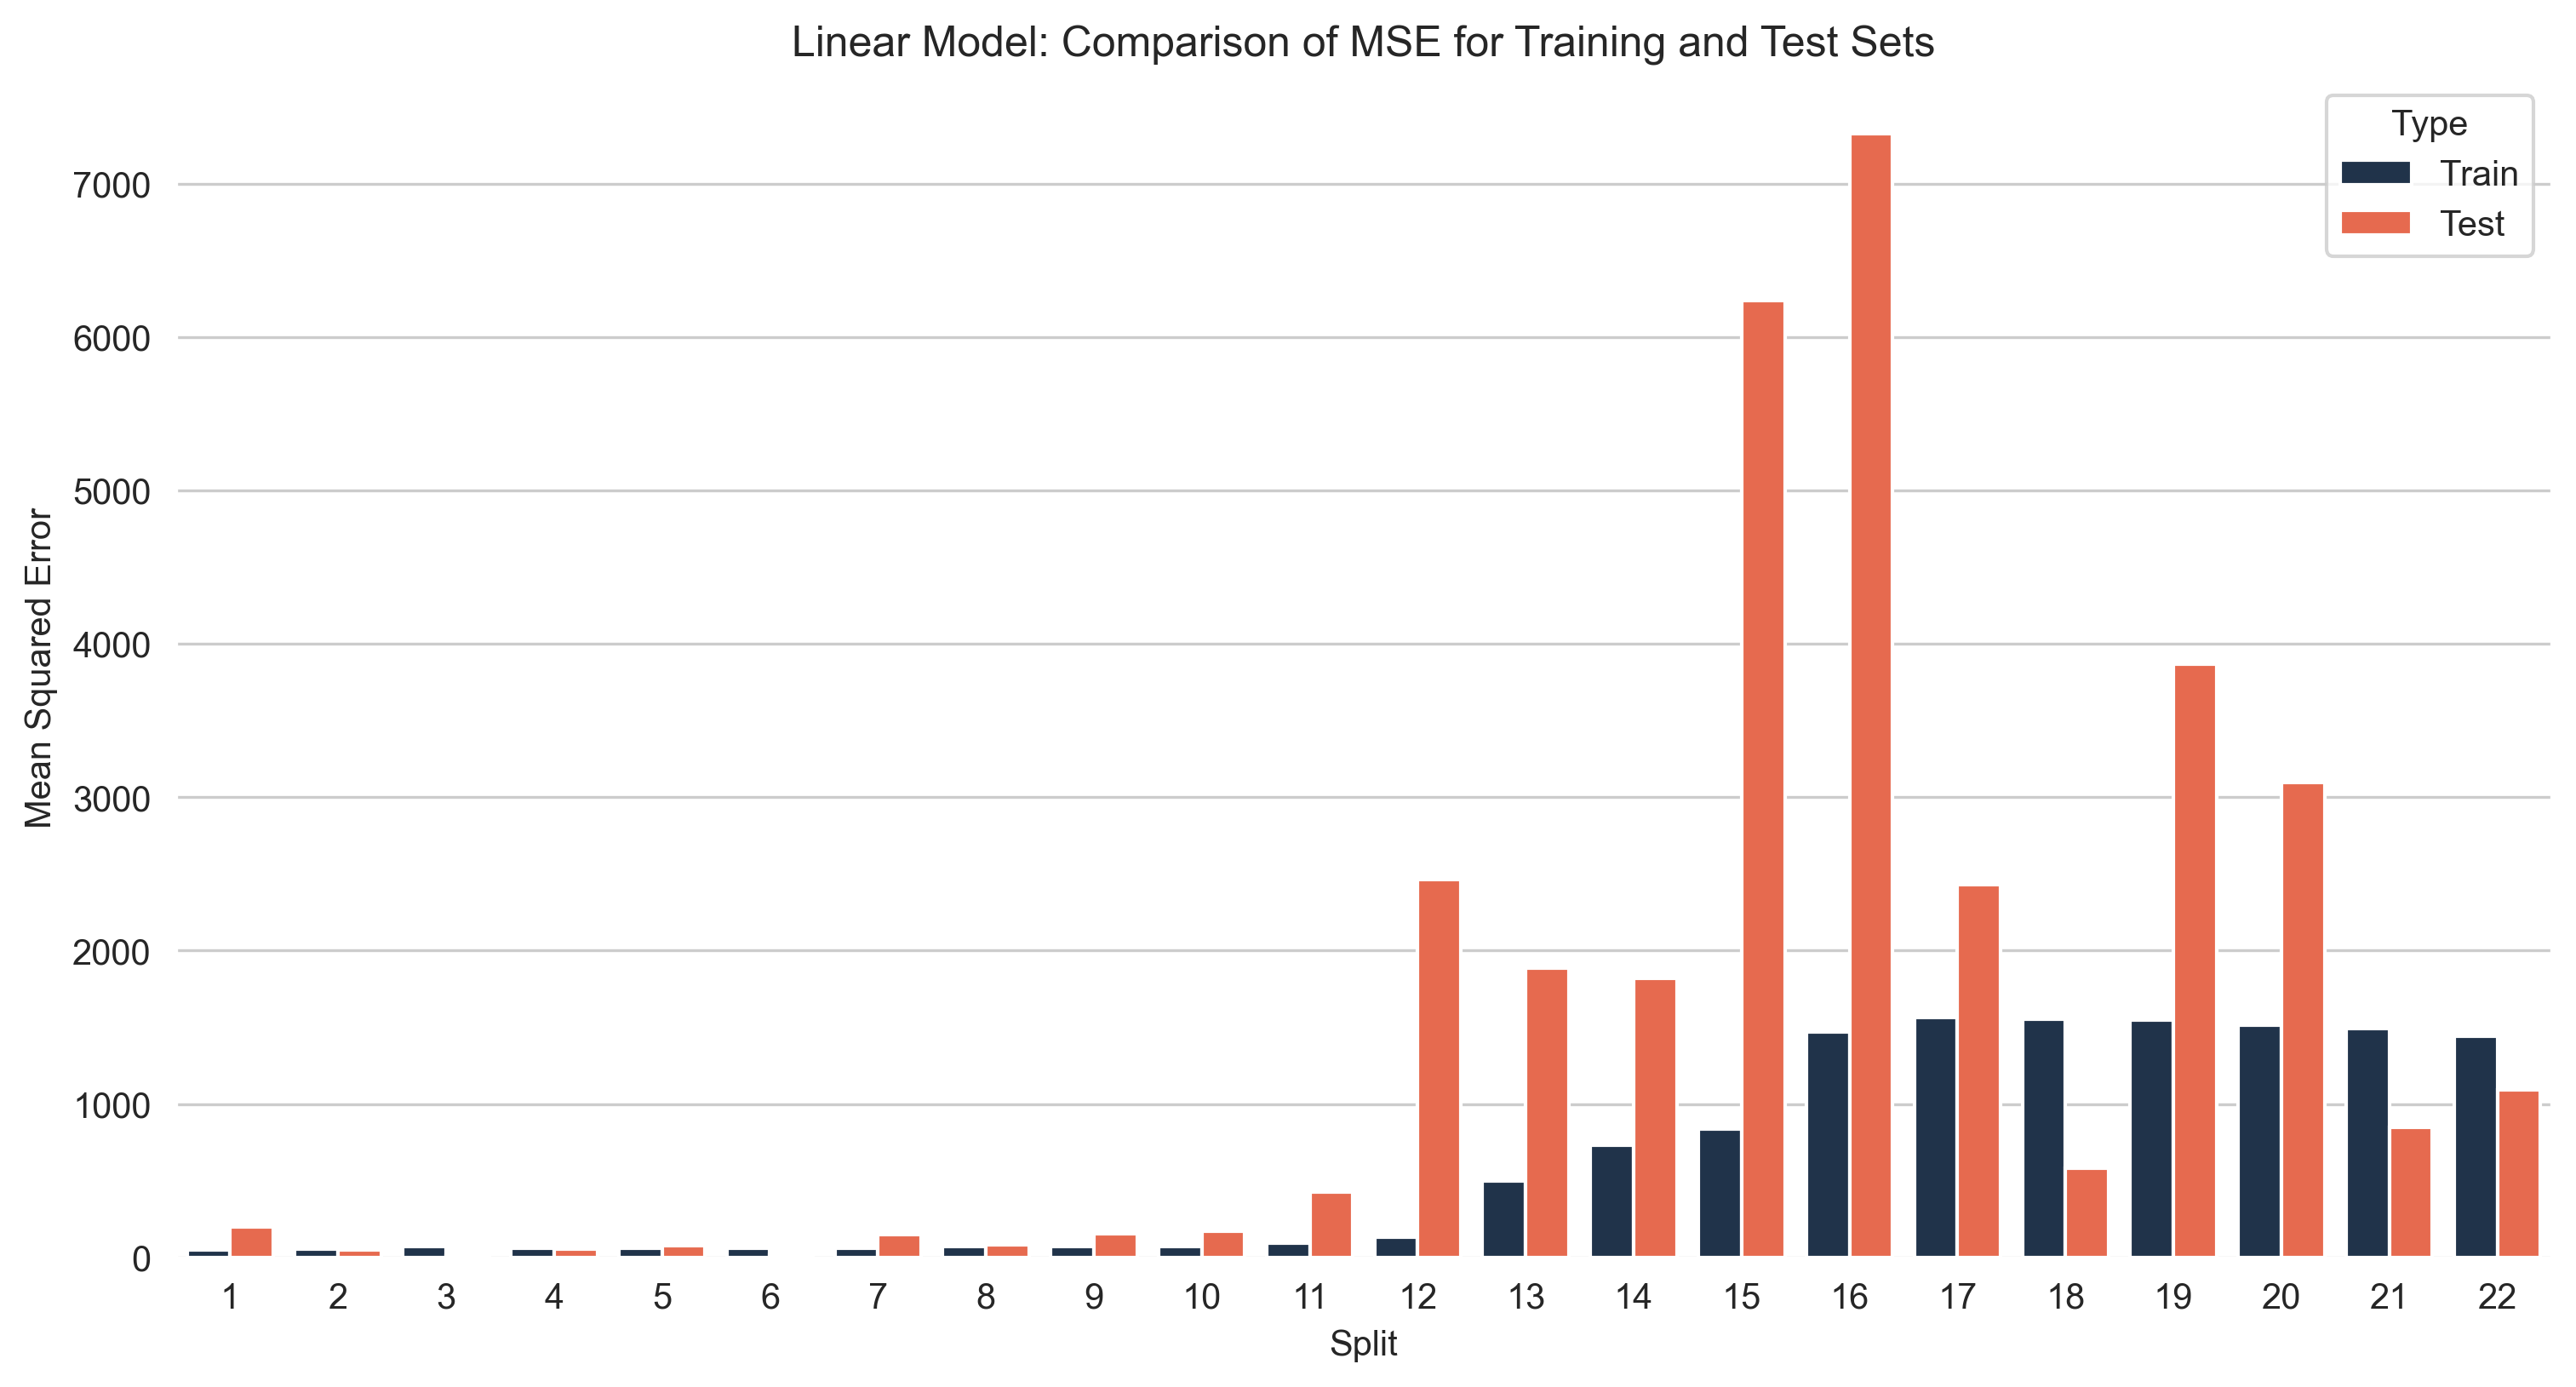

In [13]:
from sklearn.linear_model import LinearRegression

LM_mse_scores, LM_average_mse, LM_mse_score_sum, LM_plot_data = evaluate_time_series_model(X, y, LinearRegression)
plot_time_series(LM_plot_data, LM_mse_score_sum, model_name='Linear Model')

---
#### Lasso

Split 1:
MSE (train): 56.20224339724074, MSE (test): 372.1429530033351
Split 2:
MSE (train): 60.843343937739526, MSE (test): 53.25751787630578
Split 3:
MSE (train): 78.14345751335328, MSE (test): 10.41135348282832
Split 4:
MSE (train): 70.12923380618655, MSE (test): 36.93576313901926
Split 5:
MSE (train): 65.85910096877348, MSE (test): 60.28958381520917
Split 6:
MSE (train): 62.84875457918201, MSE (test): 20.114037129644288
Split 7:
MSE (train): 65.34762483938518, MSE (test): 97.45403728447029
Split 8:
MSE (train): 75.16135862064914, MSE (test): 72.89409269400085
Split 9:
MSE (train): 76.32607405405682, MSE (test): 110.646839835707
Split 10:
MSE (train): 79.81516730645687, MSE (test): 235.52388823635232
Split 11:
MSE (train): 113.22359756531945, MSE (test): 829.4385008725707
Split 12:
MSE (train): 152.20603158104169, MSE (test): 3110.14735168755
Split 13:
MSE (train): 524.2690849307634, MSE (test): 2135.56966611356
Split 14:
MSE (train): 761.7052741684938, MSE (test): 1885.487730100244

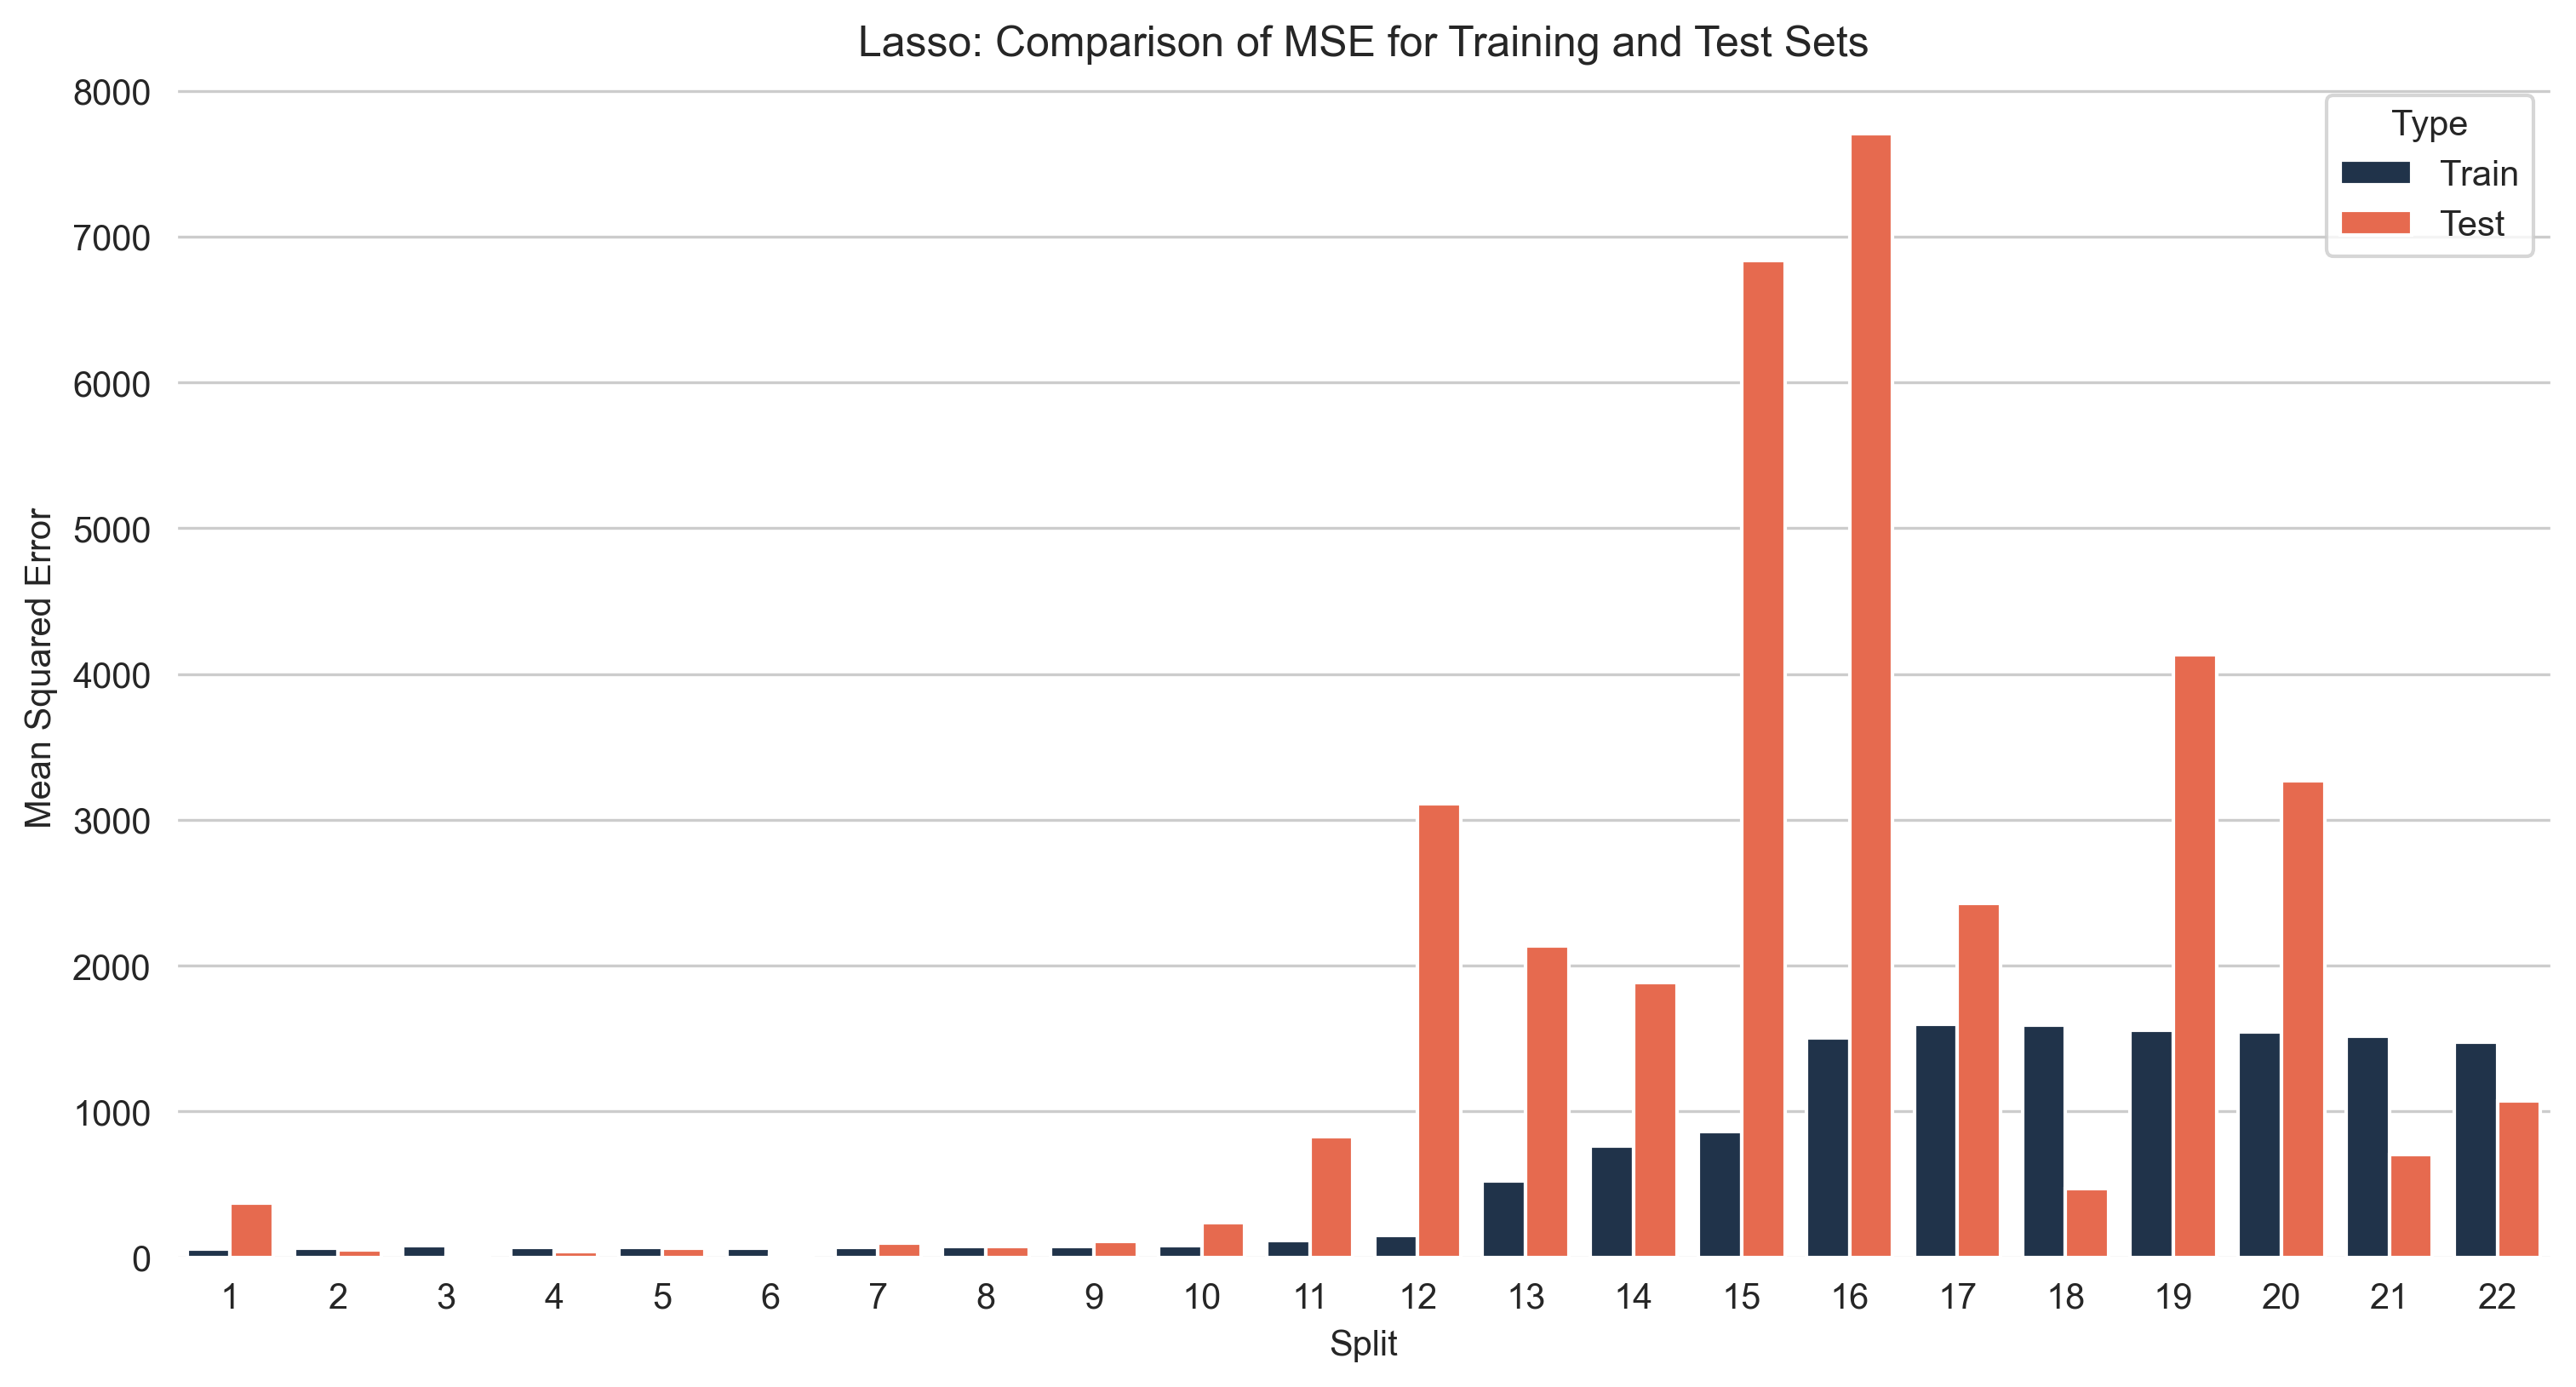

In [14]:
from sklearn.linear_model import Lasso

LASSO_mse_scores, LASSO_average_mse, LASSO_mse_score_sum, LASSO_plot_data = evaluate_time_series_model(X, y, Lasso)
plot_time_series(LASSO_plot_data, LASSO_mse_score_sum, model_name='Lasso')

---
#### Ridge

Split 1:
MSE (train): 49.559042474087704, MSE (test): 200.79446379251465
Split 2:
MSE (train): 52.05494600990067, MSE (test): 50.19254966719532
Split 3:
MSE (train): 70.1573824337589, MSE (test): 9.296055009868596
Split 4:
MSE (train): 61.68105875909493, MSE (test): 55.96297713728439
Split 5:
MSE (train): 58.343636606881155, MSE (test): 77.59680240524102
Split 6:
MSE (train): 55.61785403242133, MSE (test): 15.198165785280757
Split 7:
MSE (train): 58.41826745871144, MSE (test): 145.4003082603453
Split 8:
MSE (train): 67.02361424980053, MSE (test): 74.50626676833552
Split 9:
MSE (train): 68.33959600934881, MSE (test): 158.55235238585615
Split 10:
MSE (train): 71.37923386569724, MSE (test): 167.56435604201994
Split 11:
MSE (train): 92.40232383208647, MSE (test): 426.17712994835983
Split 12:
MSE (train): 131.57531468021378, MSE (test): 2461.356757928079
Split 13:
MSE (train): 497.5713632362302, MSE (test): 1866.8433157037678
Split 14:
MSE (train): 732.3474502189091, MSE (test): 1824.412659

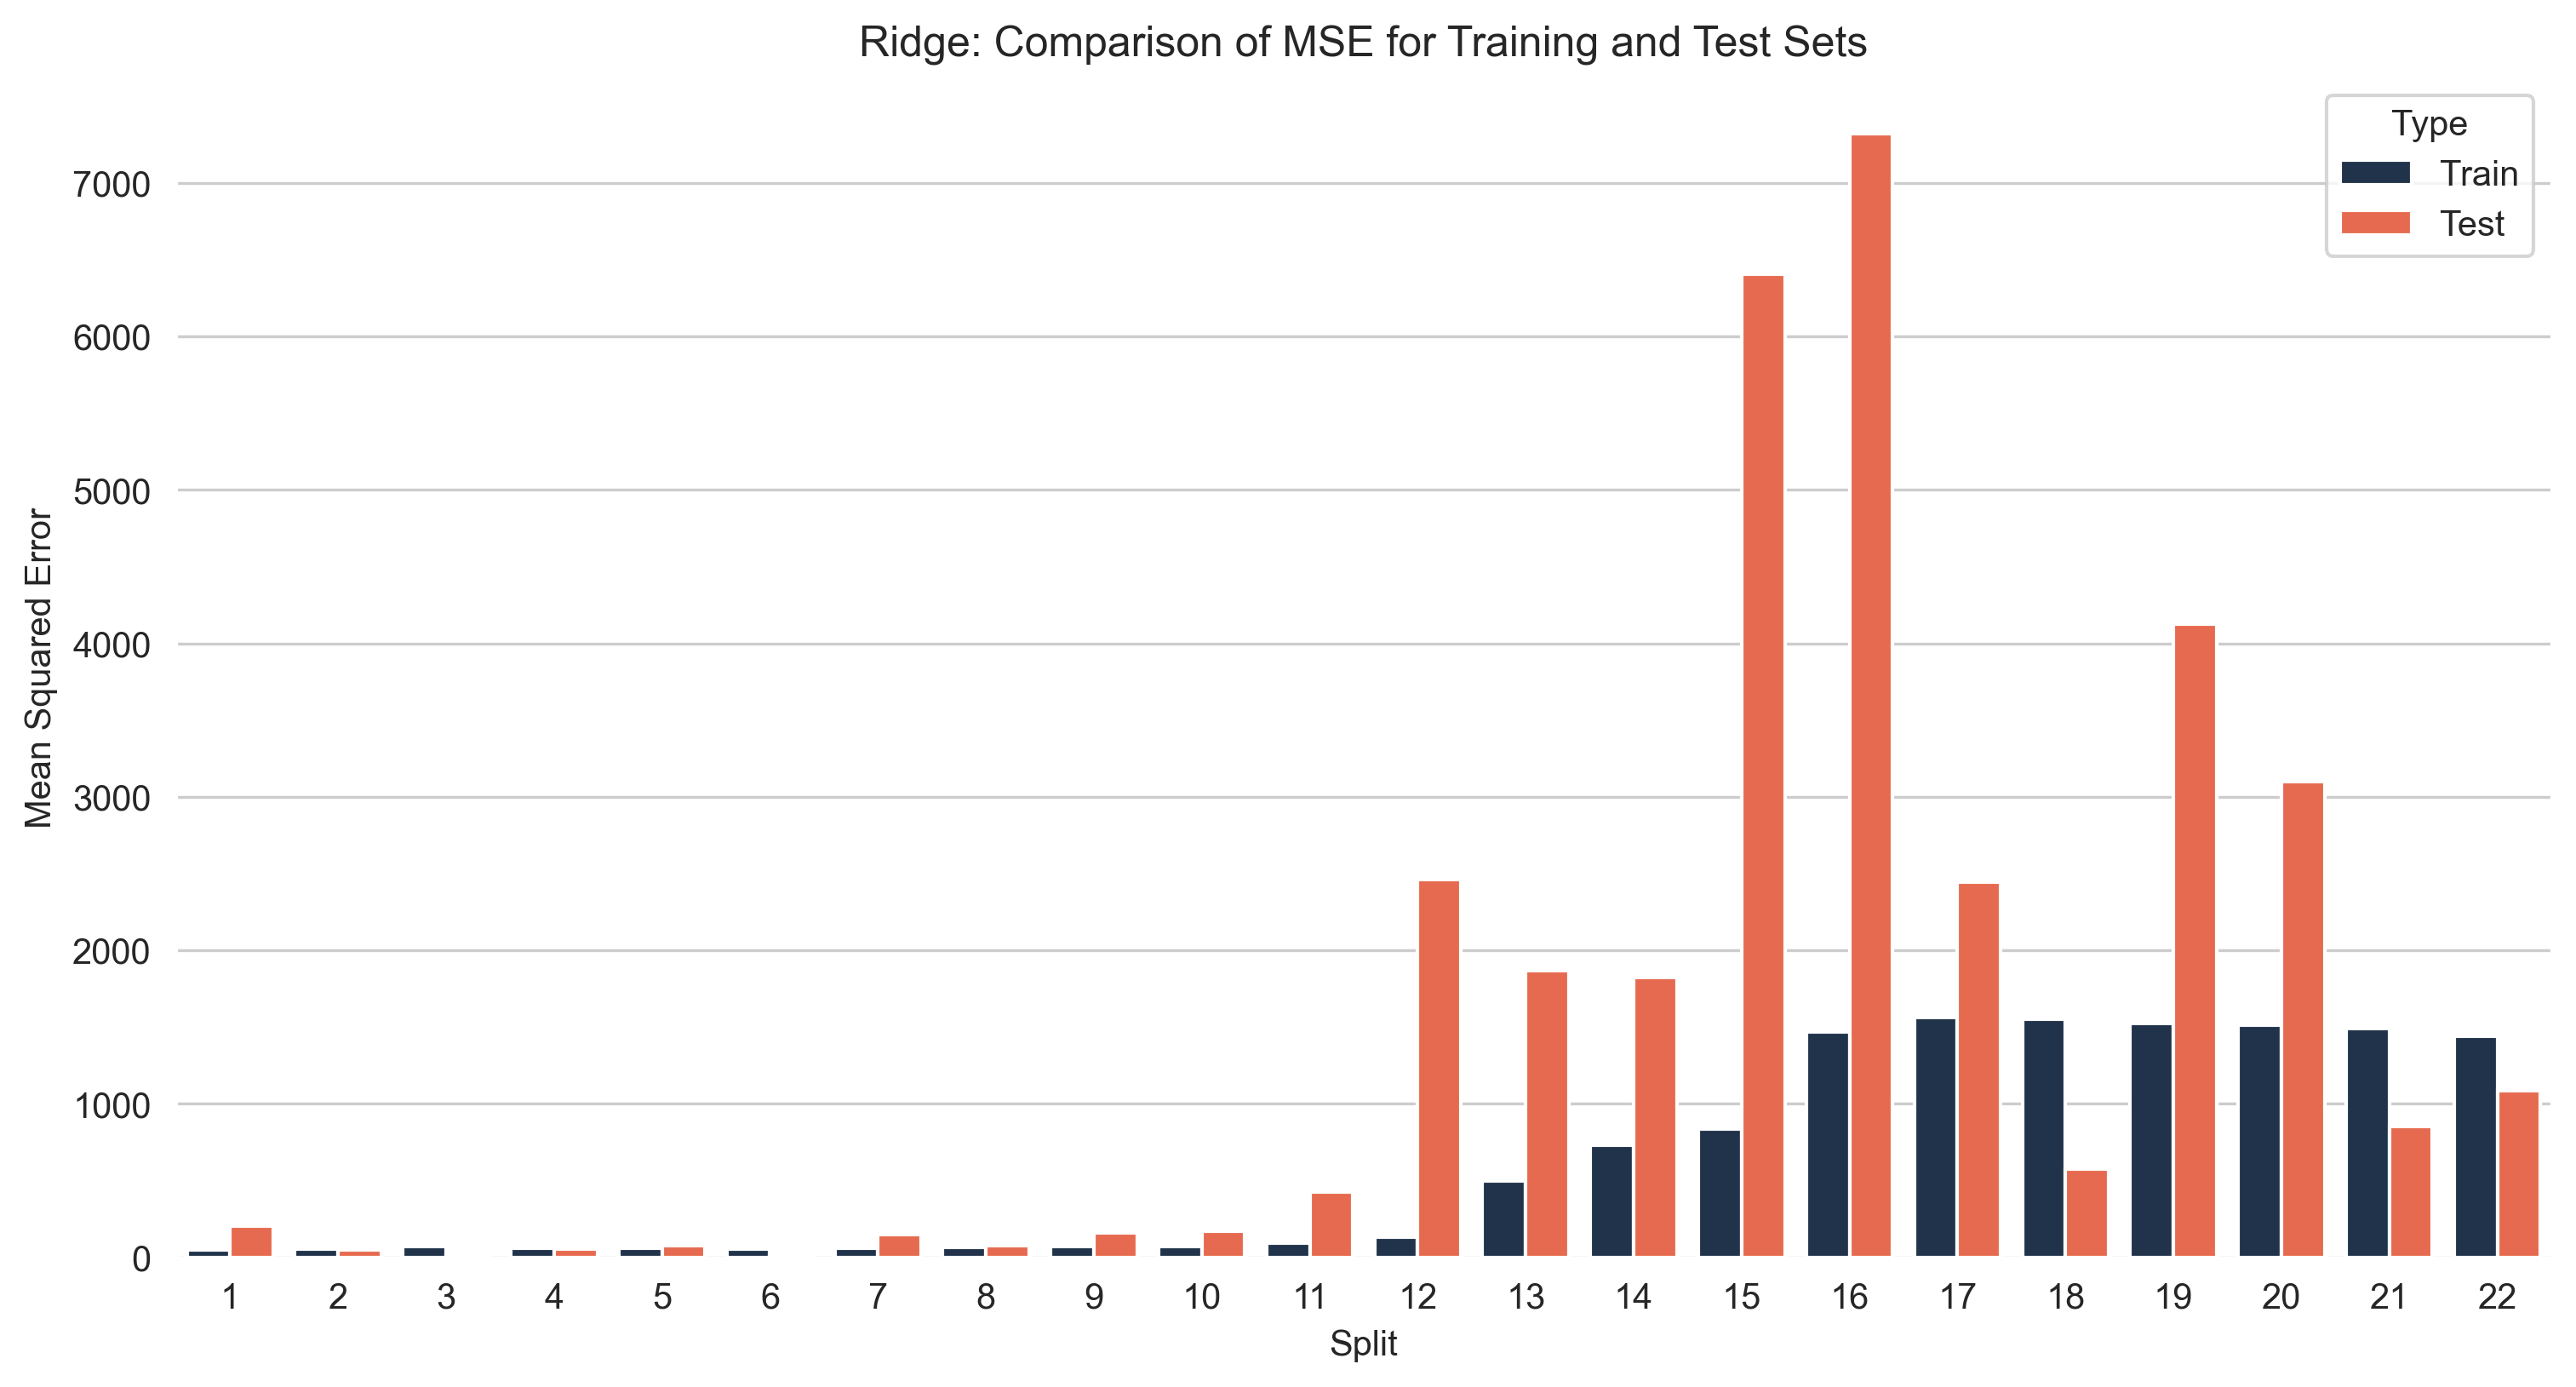

In [15]:
from sklearn.linear_model import Ridge

RIDGE_mse_scores, RIDGE_average_mse, RIDGE_mse_score_sum, RIDGE_plot_data = evaluate_time_series_model(X, y, Ridge)
plot_time_series(RIDGE_plot_data, RIDGE_mse_score_sum, model_name='Ridge')

---
#### Decision Tree

Split 1:
MSE (train): 0.0, MSE (test): 217.2605361111111
Split 2:
MSE (train): 0.0, MSE (test): 14.46392083333333
Split 3:
MSE (train): 0.0, MSE (test): 25.154347222222228
Split 4:
MSE (train): 0.0, MSE (test): 57.95741388888887
Split 5:
MSE (train): 0.0, MSE (test): 87.16140972222223
Split 6:
MSE (train): 0.0, MSE (test): 46.12788194444444
Split 7:
MSE (train): 2.4700145760344793e-33, MSE (test): 152.4612097222222
Split 8:
MSE (train): 0.0, MSE (test): 91.12147083333333
Split 9:
MSE (train): 0.0, MSE (test): 64.34376111111112
Split 10:
MSE (train): 0.0, MSE (test): 160.83352638888886
Split 11:
MSE (train): 1.5718274574764867e-33, MSE (test): 101.6180611111111
Split 12:
MSE (train): 1.4408418360201128e-33, MSE (test): 1392.2708263888887
Split 13:
MSE (train): 2.0294309213774878e-38, MSE (test): 1517.5074708333332
Split 14:
MSE (train): 1.8844715698505244e-38, MSE (test): 837.8147319444444
Split 15:
MSE (train): 4.61071146366568e-33, MSE (test): 1560.7046277777777
Split 16:
MSE (train):

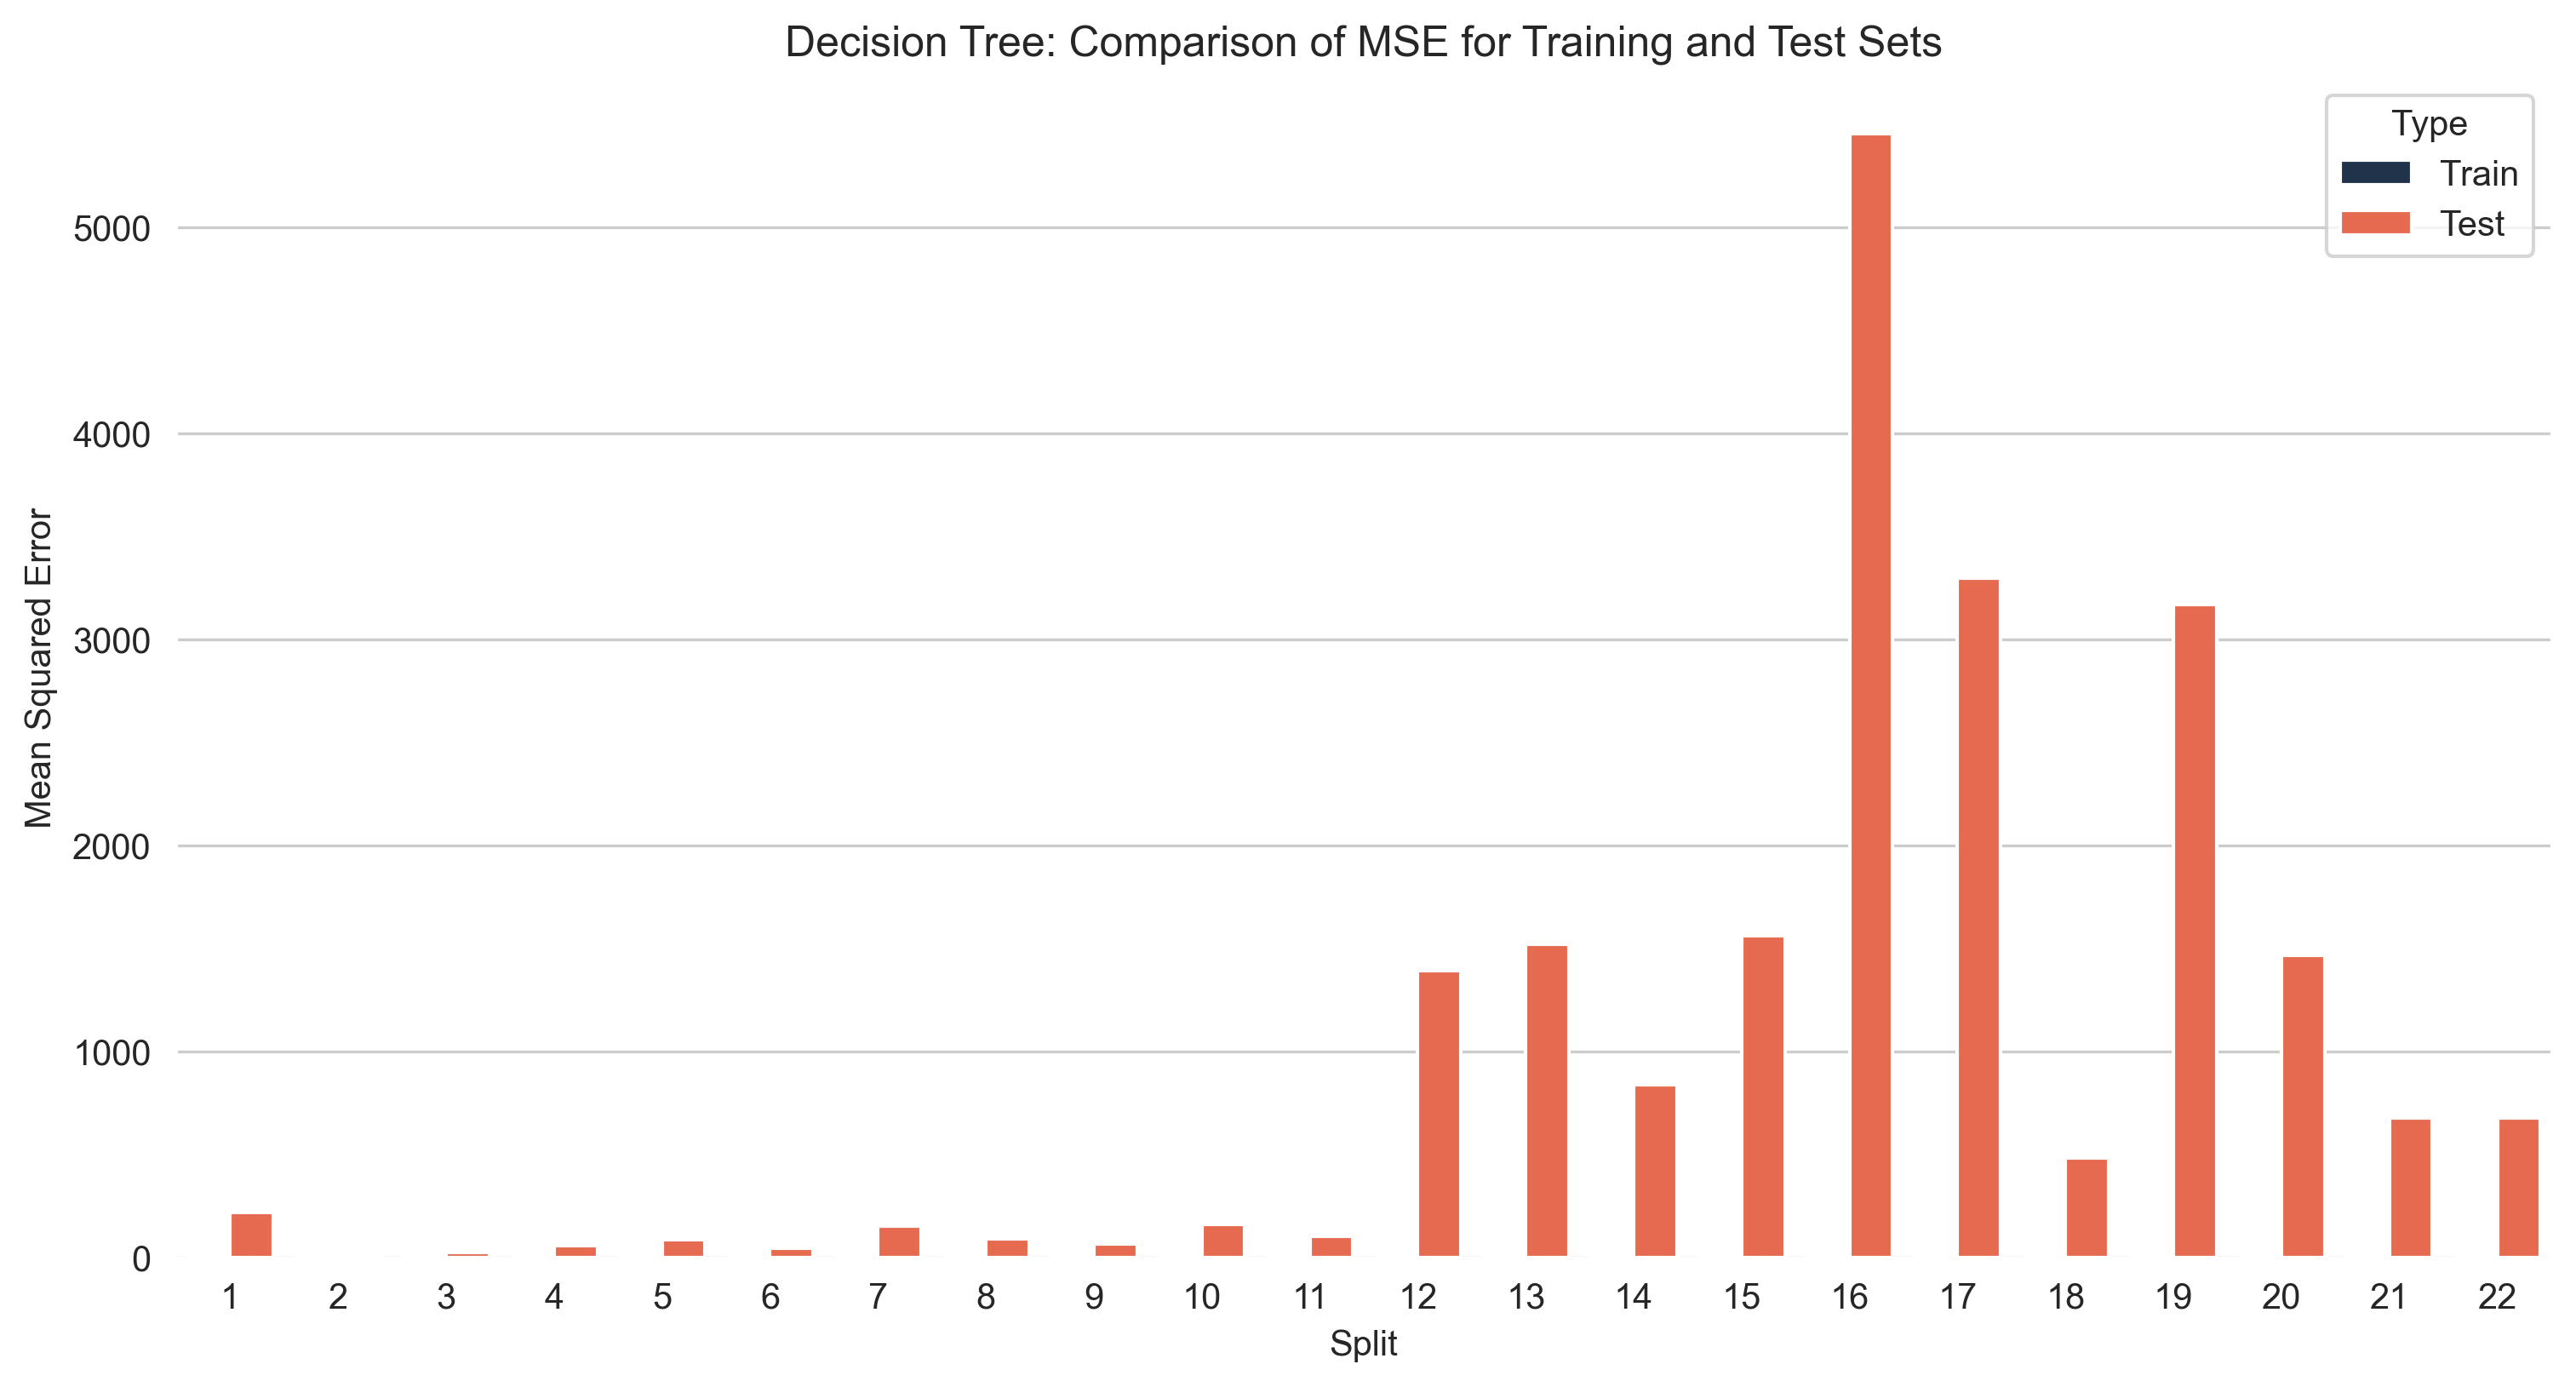

In [16]:
from sklearn.tree import DecisionTreeRegressor

DT_mse_scores, DT_average_mse, DT_mse_score_sum, DT_plot_data = evaluate_time_series_model(X, y, DecisionTreeRegressor)
plot_time_series(DT_plot_data, DT_mse_score_sum, model_name='Decision Tree')

---

#### Random Forest

Split 1:
MSE (train): 2.338976515566207, MSE (test): 156.36188178347226
Split 2:
MSE (train): 2.0677106307671234, MSE (test): 8.345262797499988
Split 3:
MSE (train): 2.299915151748857, MSE (test): 15.665822873749997
Split 4:
MSE (train): 2.10533802022146, MSE (test): 9.580764068888893
Split 5:
MSE (train): 2.006025974505023, MSE (test): 61.445569616805564
Split 6:
MSE (train): 1.9976539155487063, MSE (test): 11.340636745694436
Split 7:
MSE (train): 2.044418836084801, MSE (test): 263.3996892195834
Split 8:
MSE (train): 2.3486291842642673, MSE (test): 53.78238982750002
Split 9:
MSE (train): 2.3639361994398773, MSE (test): 33.78805429097227
Split 10:
MSE (train): 2.4774941428497703, MSE (test): 106.50278345861099
Split 11:
MSE (train): 2.7392065528156913, MSE (test): 92.62119362430543
Split 12:
MSE (train): 3.091880847348173, MSE (test): 1398.7676878879167
Split 13:
MSE (train): 5.9816609846617546, MSE (test): 676.81915141125
Split 14:
MSE (train): 10.083299554397259, MSE (test): 436.3521

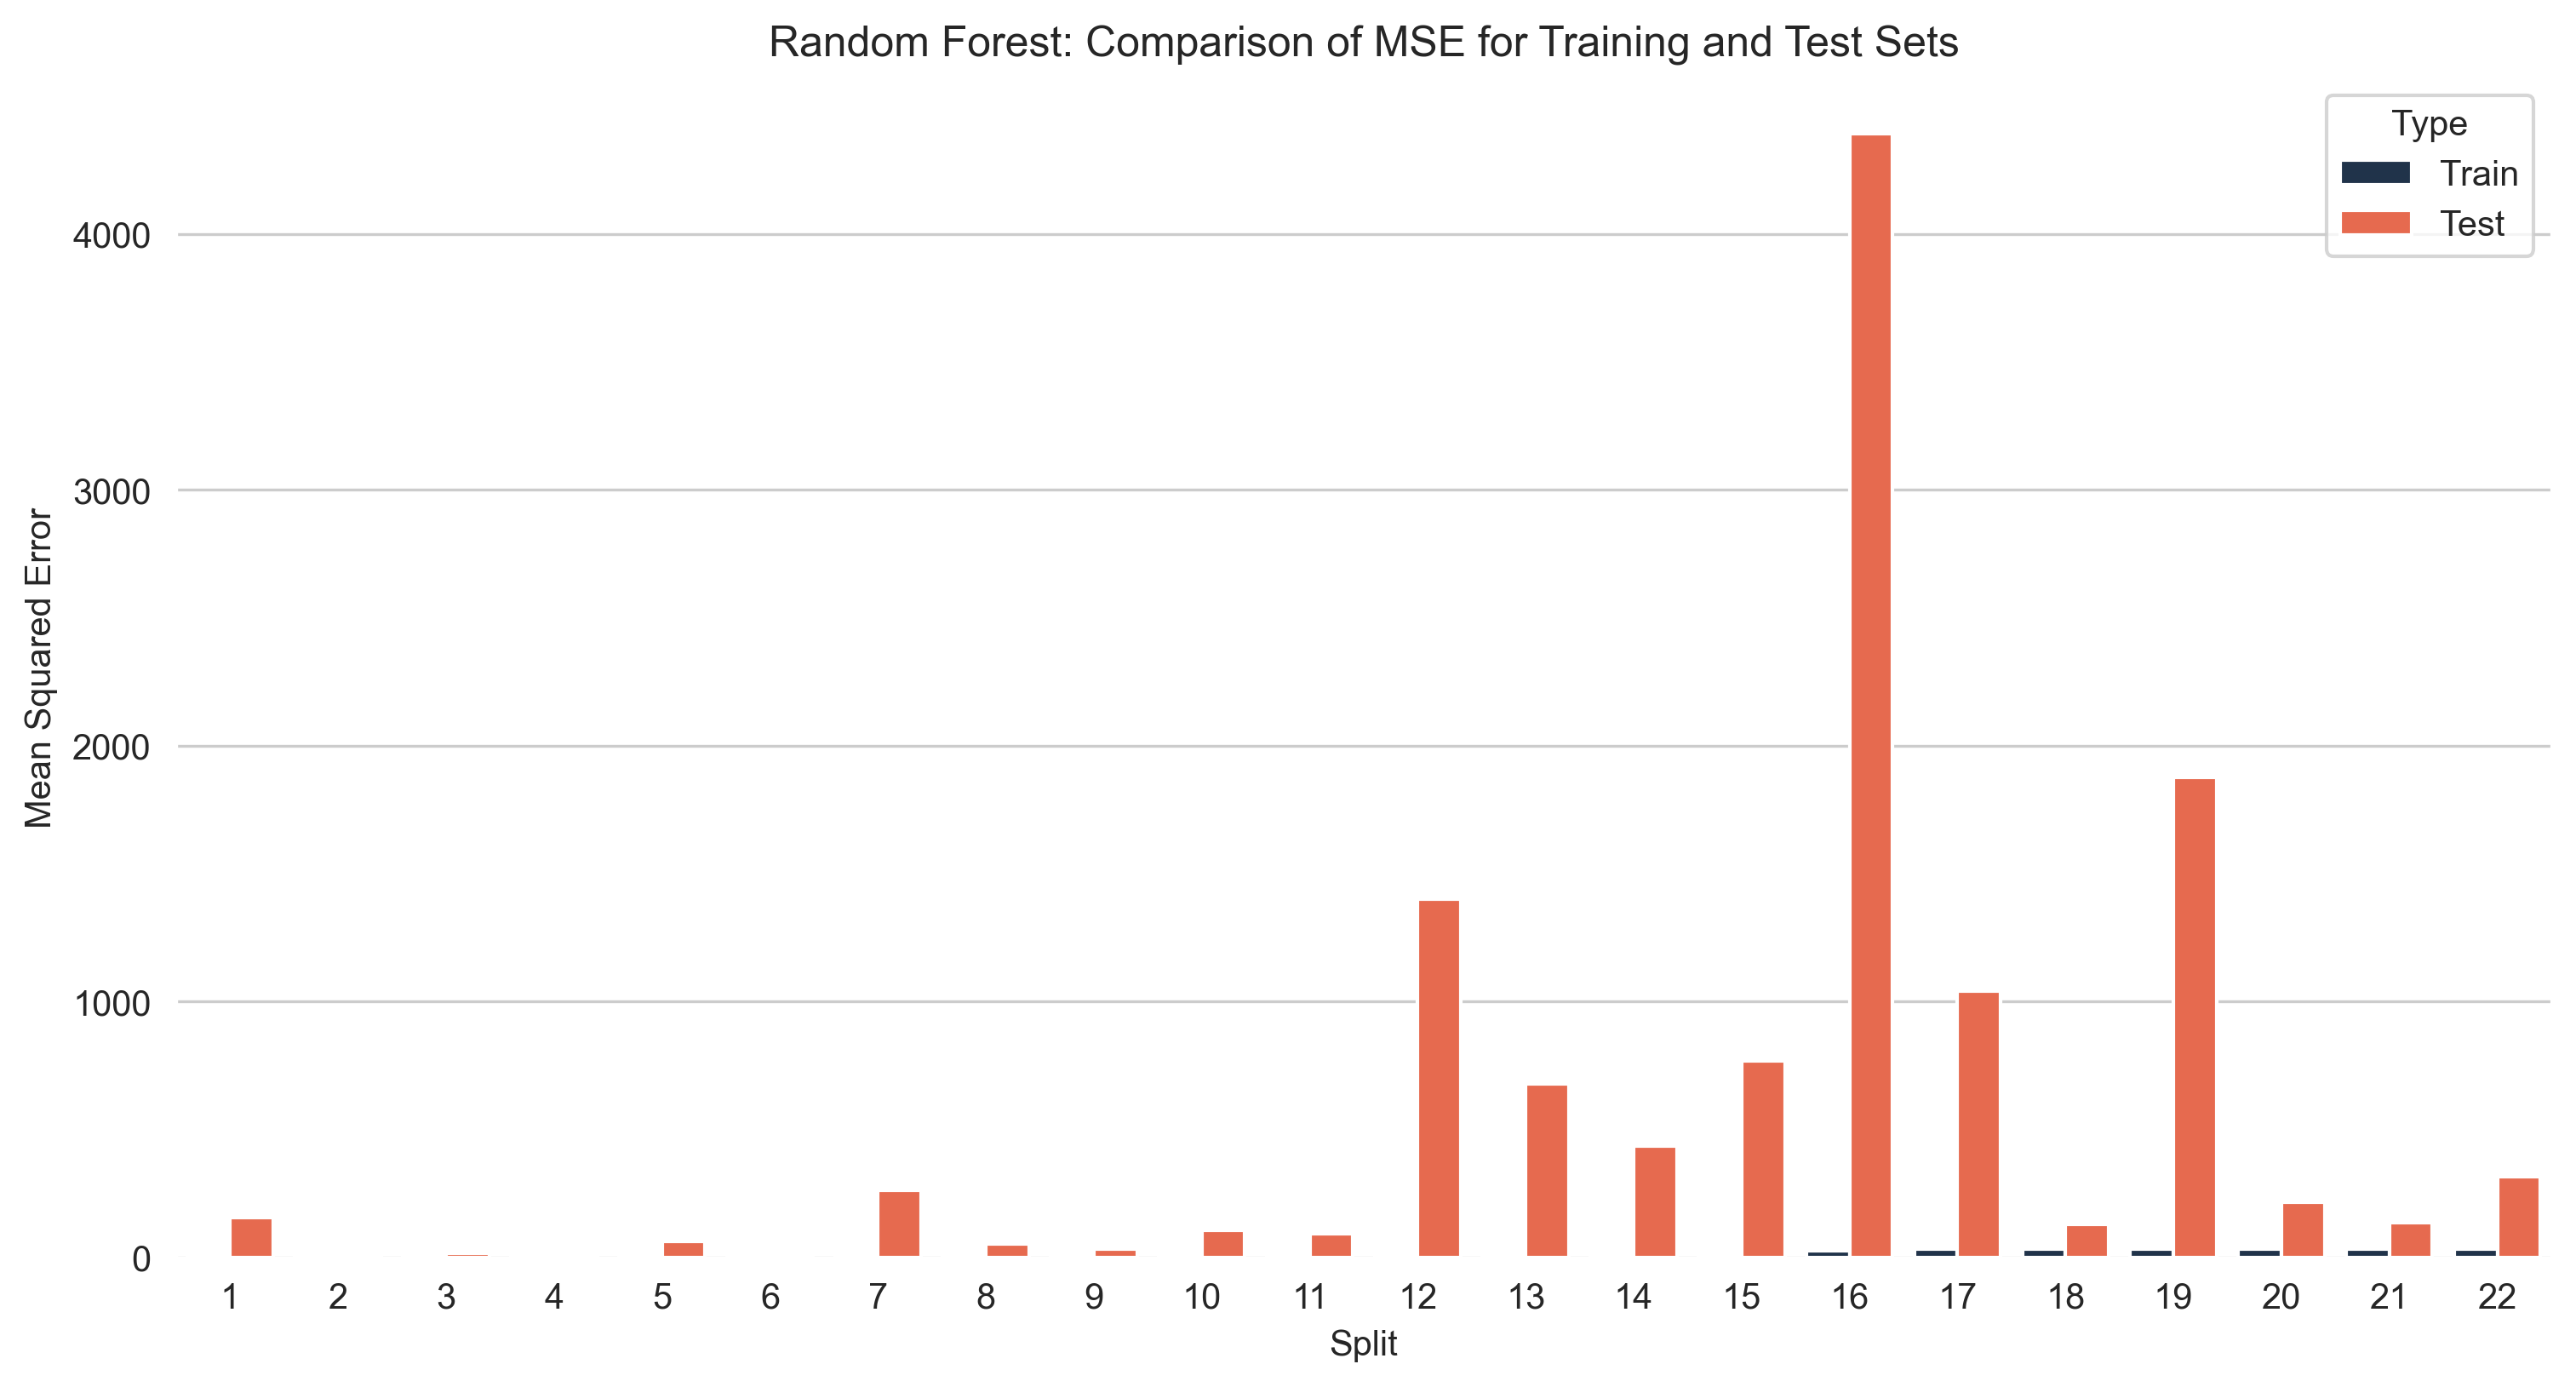

In [17]:
from sklearn.ensemble import RandomForestRegressor

RF_mse_scores, RF_average_mse, RF_mse_score_sum, RF_plot_data = evaluate_time_series_model(X, y, RandomForestRegressor)
plot_time_series(RF_plot_data, RF_mse_score_sum, model_name='Random Forest')

---
#### GradientBoost

Split 1:
MSE (train): 12.472564483706764, MSE (test): 191.57539930598443
Split 2:
MSE (train): 15.243064912713248, MSE (test): 8.854496141720793
Split 3:
MSE (train): 16.836617049709393, MSE (test): 14.659036772318595
Split 4:
MSE (train): 17.22764031863873, MSE (test): 7.885983035402646
Split 5:
MSE (train): 17.983840313238392, MSE (test): 46.74617817619665
Split 6:
MSE (train): 19.553294958529403, MSE (test): 9.251329116937347
Split 7:
MSE (train): 21.183228442782944, MSE (test): 258.38908209620865
Split 8:
MSE (train): 22.993089358361942, MSE (test): 74.17350924095962
Split 9:
MSE (train): 24.742808598395218, MSE (test): 10.358168989854462
Split 10:
MSE (train): 26.06410420415012, MSE (test): 56.32506764600876
Split 11:
MSE (train): 31.500253539934373, MSE (test): 73.02277012487487
Split 12:
MSE (train): 35.82726810964302, MSE (test): 822.6287212718617
Split 13:
MSE (train): 76.6169786686832, MSE (test): 1287.195886892476
Split 14:
MSE (train): 132.14560084719685, MSE (test): 294.01

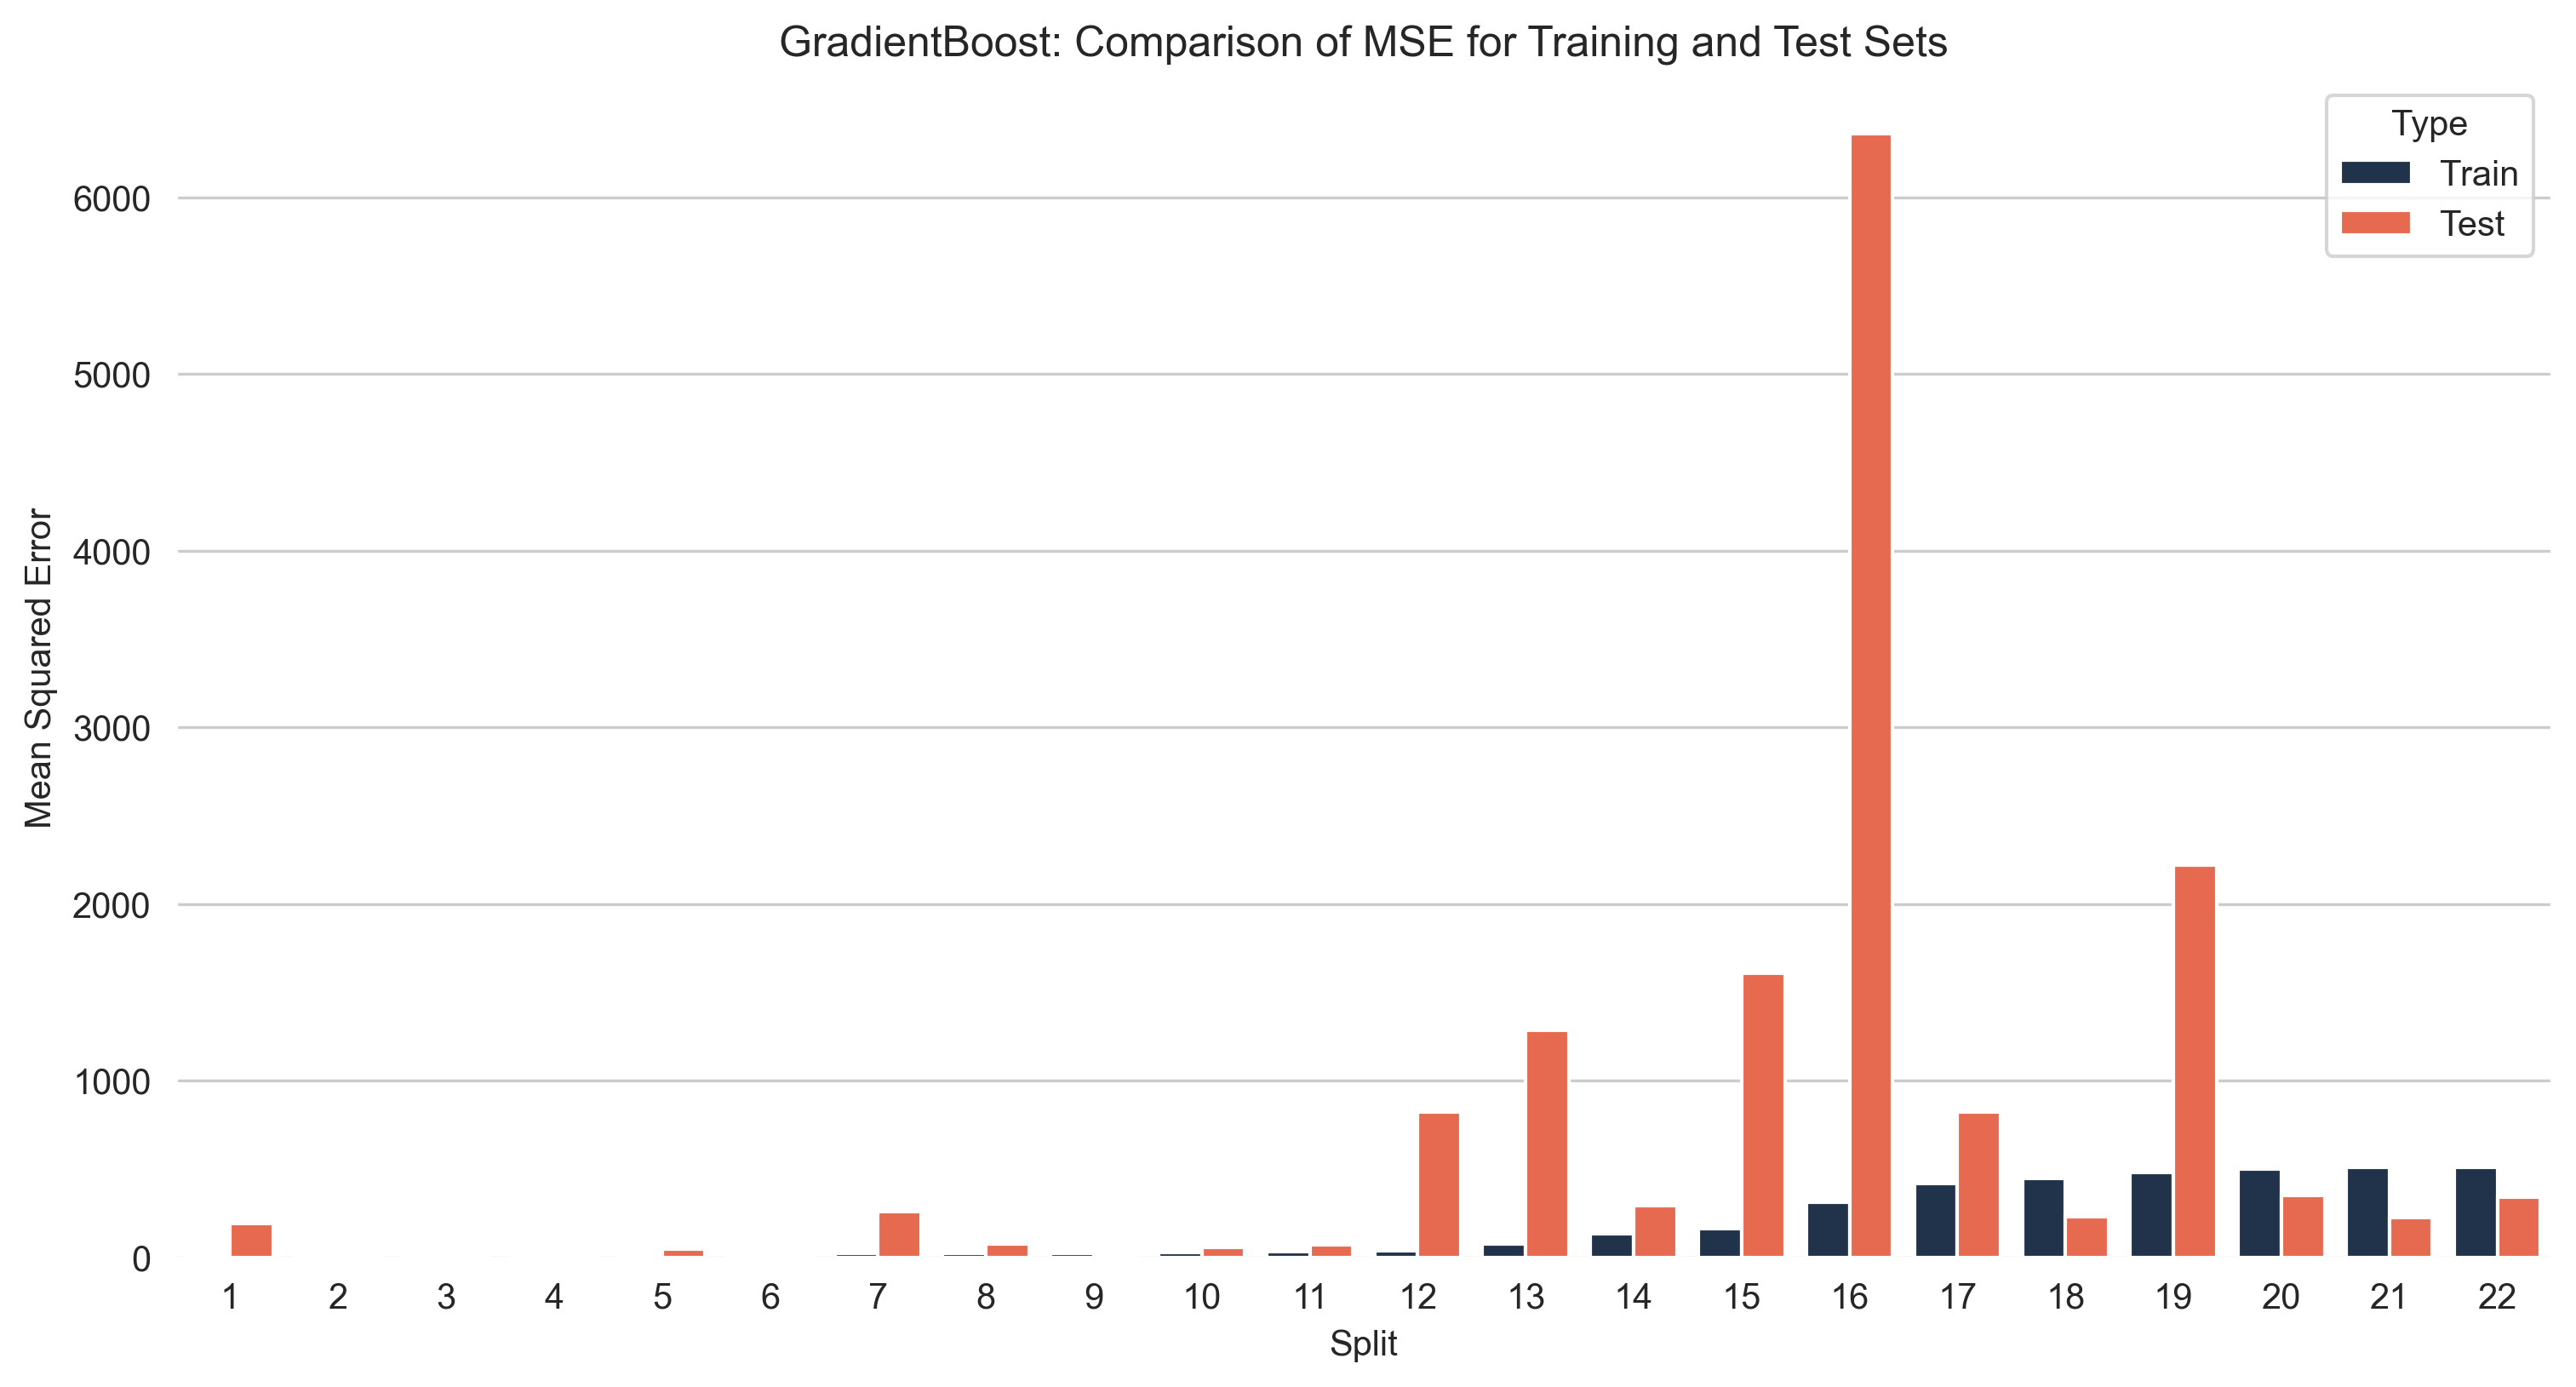

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

GB_mse_scores, GB_average_mse, GB_mse_score_sum, GB_plot_data = evaluate_time_series_model(X, y, GradientBoostingRegressor)
plot_time_series(GB_plot_data, GB_mse_score_sum, model_name='GradientBoost')

---
#### HistGradientBoost

Split 1:
MSE (train): 2.5946437846562946, MSE (test): 162.19633939370505
Split 2:
MSE (train): 4.456831854958261, MSE (test): 6.635499978907886
Split 3:
MSE (train): 6.225443510084894, MSE (test): 14.727134360616553
Split 4:
MSE (train): 6.964334225777036, MSE (test): 9.265536967009023
Split 5:
MSE (train): 8.413131114543068, MSE (test): 57.153943988986356
Split 6:
MSE (train): 9.006302755810088, MSE (test): 10.879165365710023
Split 7:
MSE (train): 10.144273987603189, MSE (test): 409.10765118193444
Split 8:
MSE (train): 11.21348923233016, MSE (test): 62.11848459567609
Split 9:
MSE (train): 12.021913145430933, MSE (test): 13.50503357283609
Split 10:
MSE (train): 13.214686752067859, MSE (test): 31.30375575064713
Split 11:
MSE (train): 15.886554969601498, MSE (test): 74.06045890763764
Split 12:
MSE (train): 18.984623965146625, MSE (test): 1236.9346320536986
Split 13:
MSE (train): 34.4886442949362, MSE (test): 886.1921636413556
Split 14:
MSE (train): 57.42406953356871, MSE (test): 391.8107

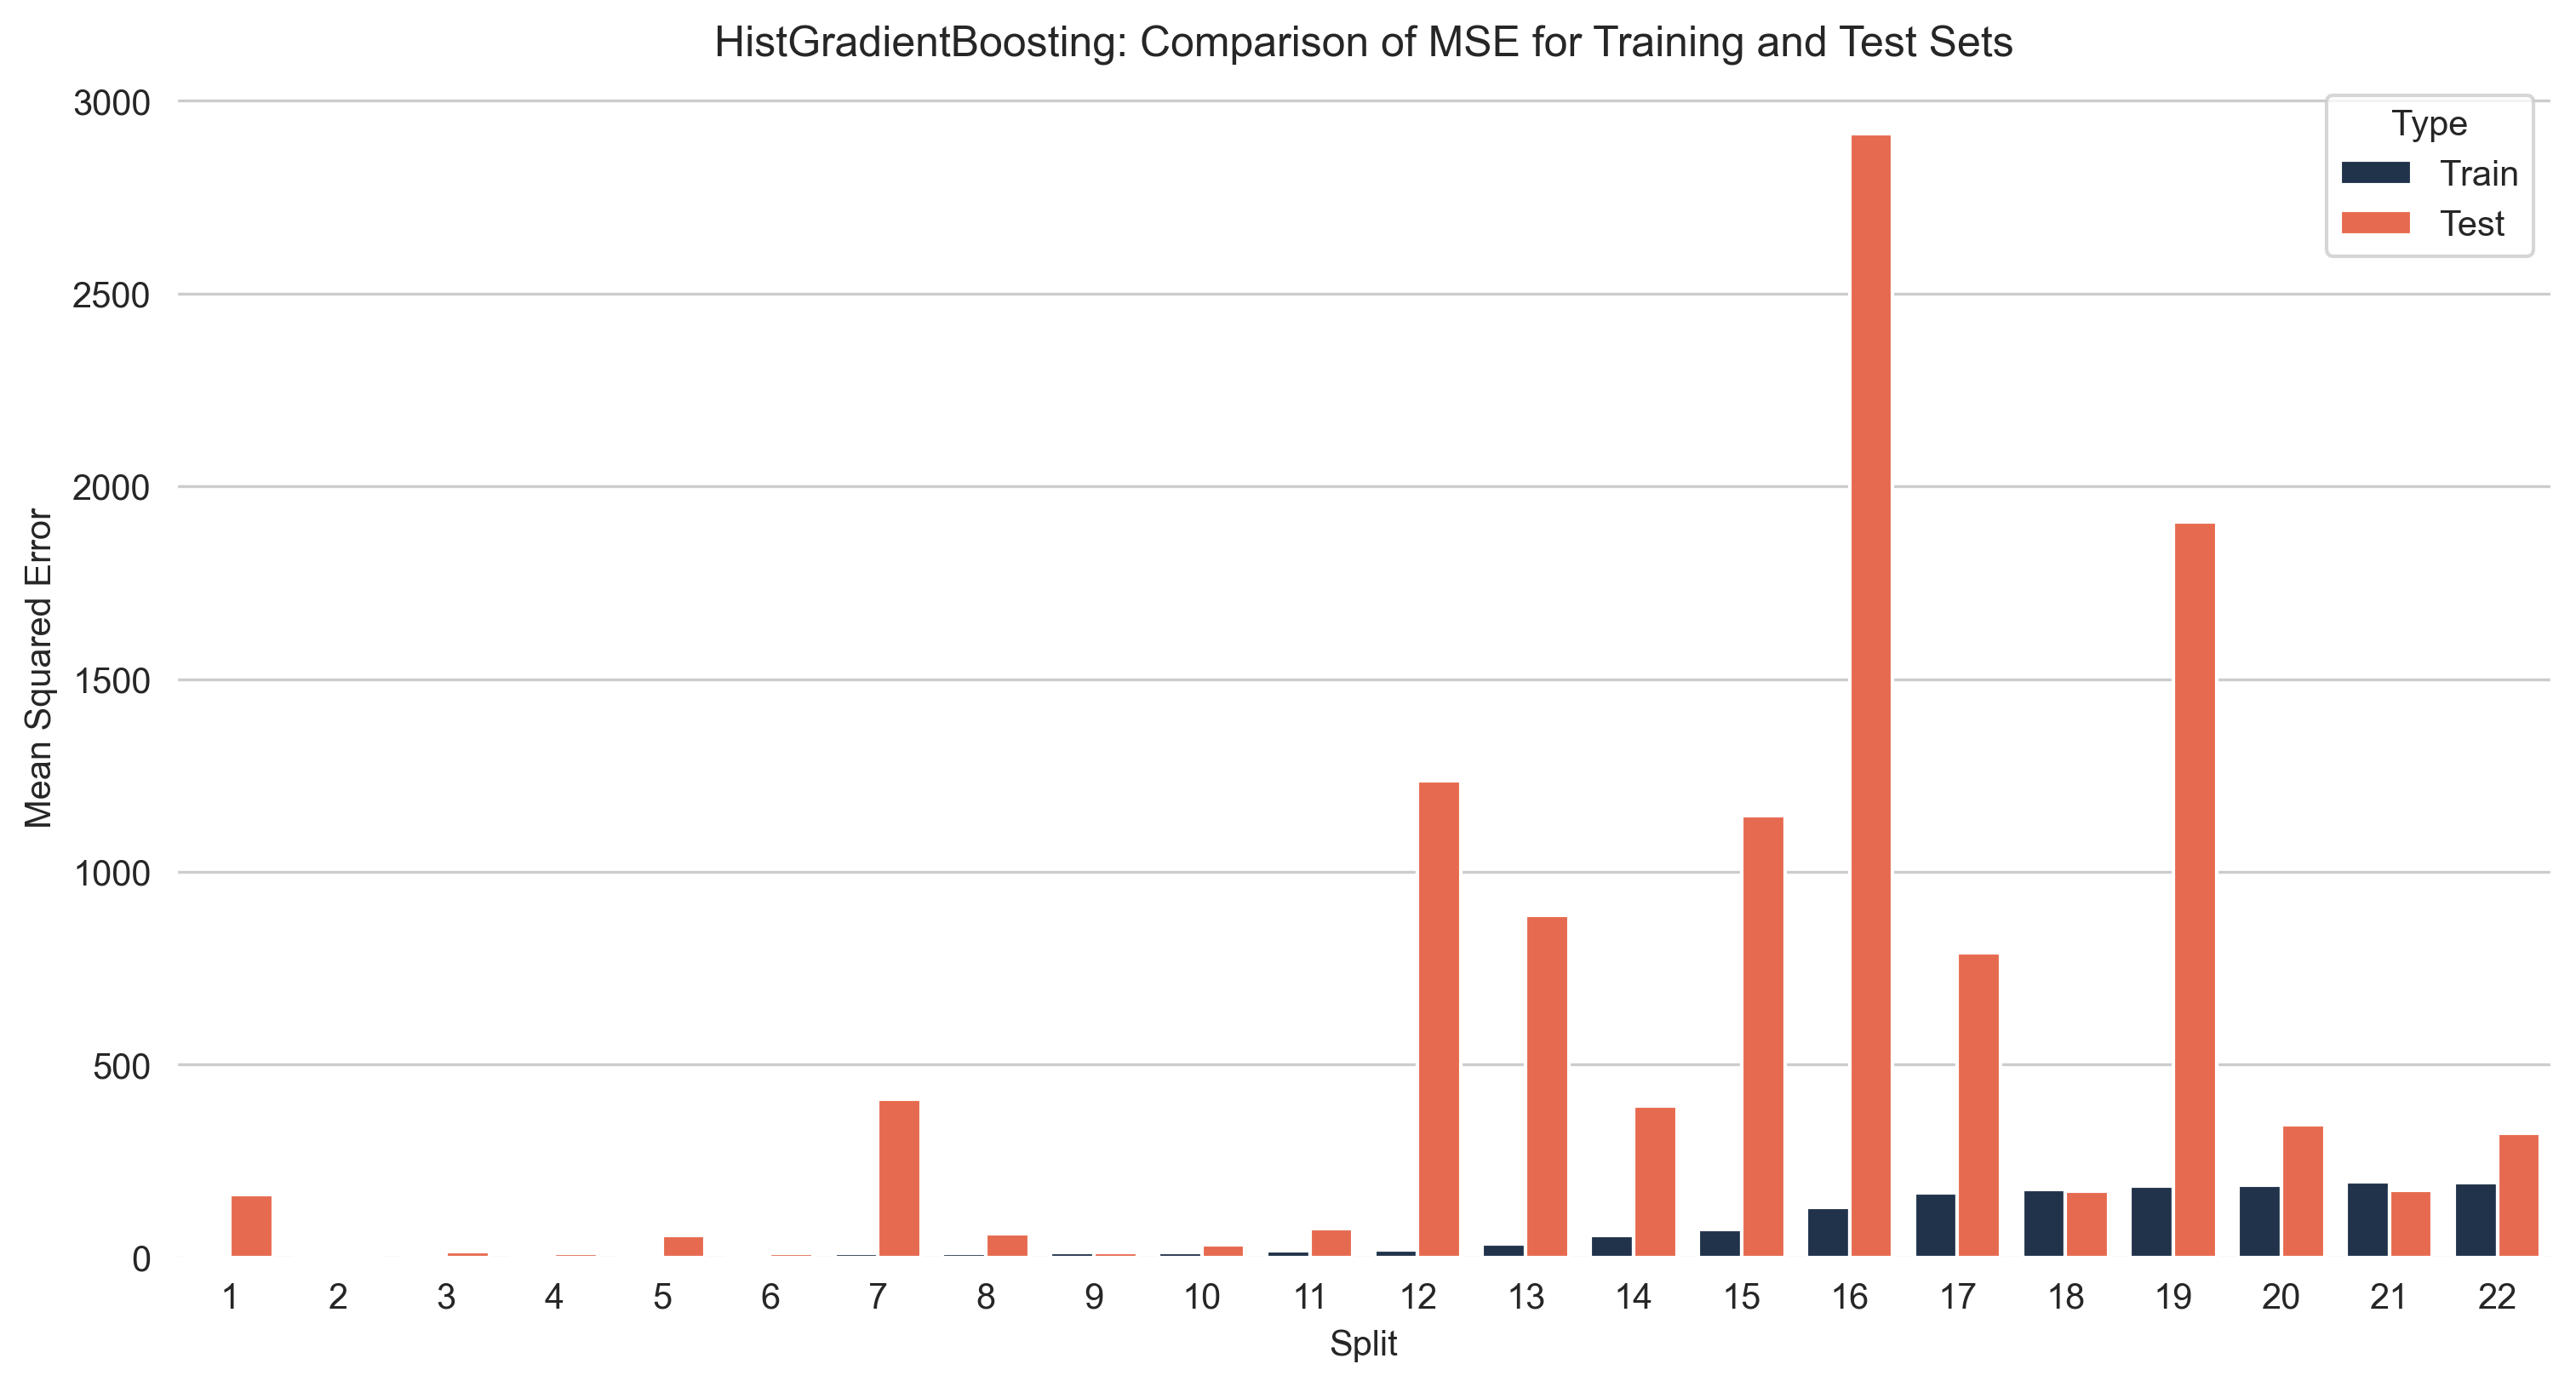

In [19]:
from sklearn.ensemble import HistGradientBoostingRegressor

HGB_mse_scores, HGB_average_mse, HGB_mse_score_sum, HGB_plot_data = evaluate_time_series_model(X, y, HistGradientBoostingRegressor)
plot_time_series(HGB_plot_data, HGB_mse_score_sum, model_name='HistGradientBoosting')

---

#### AdaBoostRegressor

Split 1:
MSE (train): 36.26456740023397, MSE (test): 183.66854989376748
Split 2:
MSE (train): 49.13532724421225, MSE (test): 155.92071094125924
Split 3:
MSE (train): 55.80219505193342, MSE (test): 19.14368442429026
Split 4:
MSE (train): 55.71998677376135, MSE (test): 18.087356076146307
Split 5:
MSE (train): 51.675112147382855, MSE (test): 46.77496689094445
Split 6:
MSE (train): 54.0340225480939, MSE (test): 45.60282241380056
Split 7:
MSE (train): 53.71055838496443, MSE (test): 212.33347801242385
Split 8:
MSE (train): 69.44675263116389, MSE (test): 78.52214858356716
Split 9:
MSE (train): 74.48050605685971, MSE (test): 40.67755727436448
Split 10:
MSE (train): 74.73537451952251, MSE (test): 397.8877247577341
Split 11:
MSE (train): 107.41804601413692, MSE (test): 283.4721845743291
Split 12:
MSE (train): 182.3472816900628, MSE (test): 646.5915665787431
Split 13:
MSE (train): 435.70081200388944, MSE (test): 582.3035789829183
Split 14:
MSE (train): 552.7694554264101, MSE (test): 427.634929972

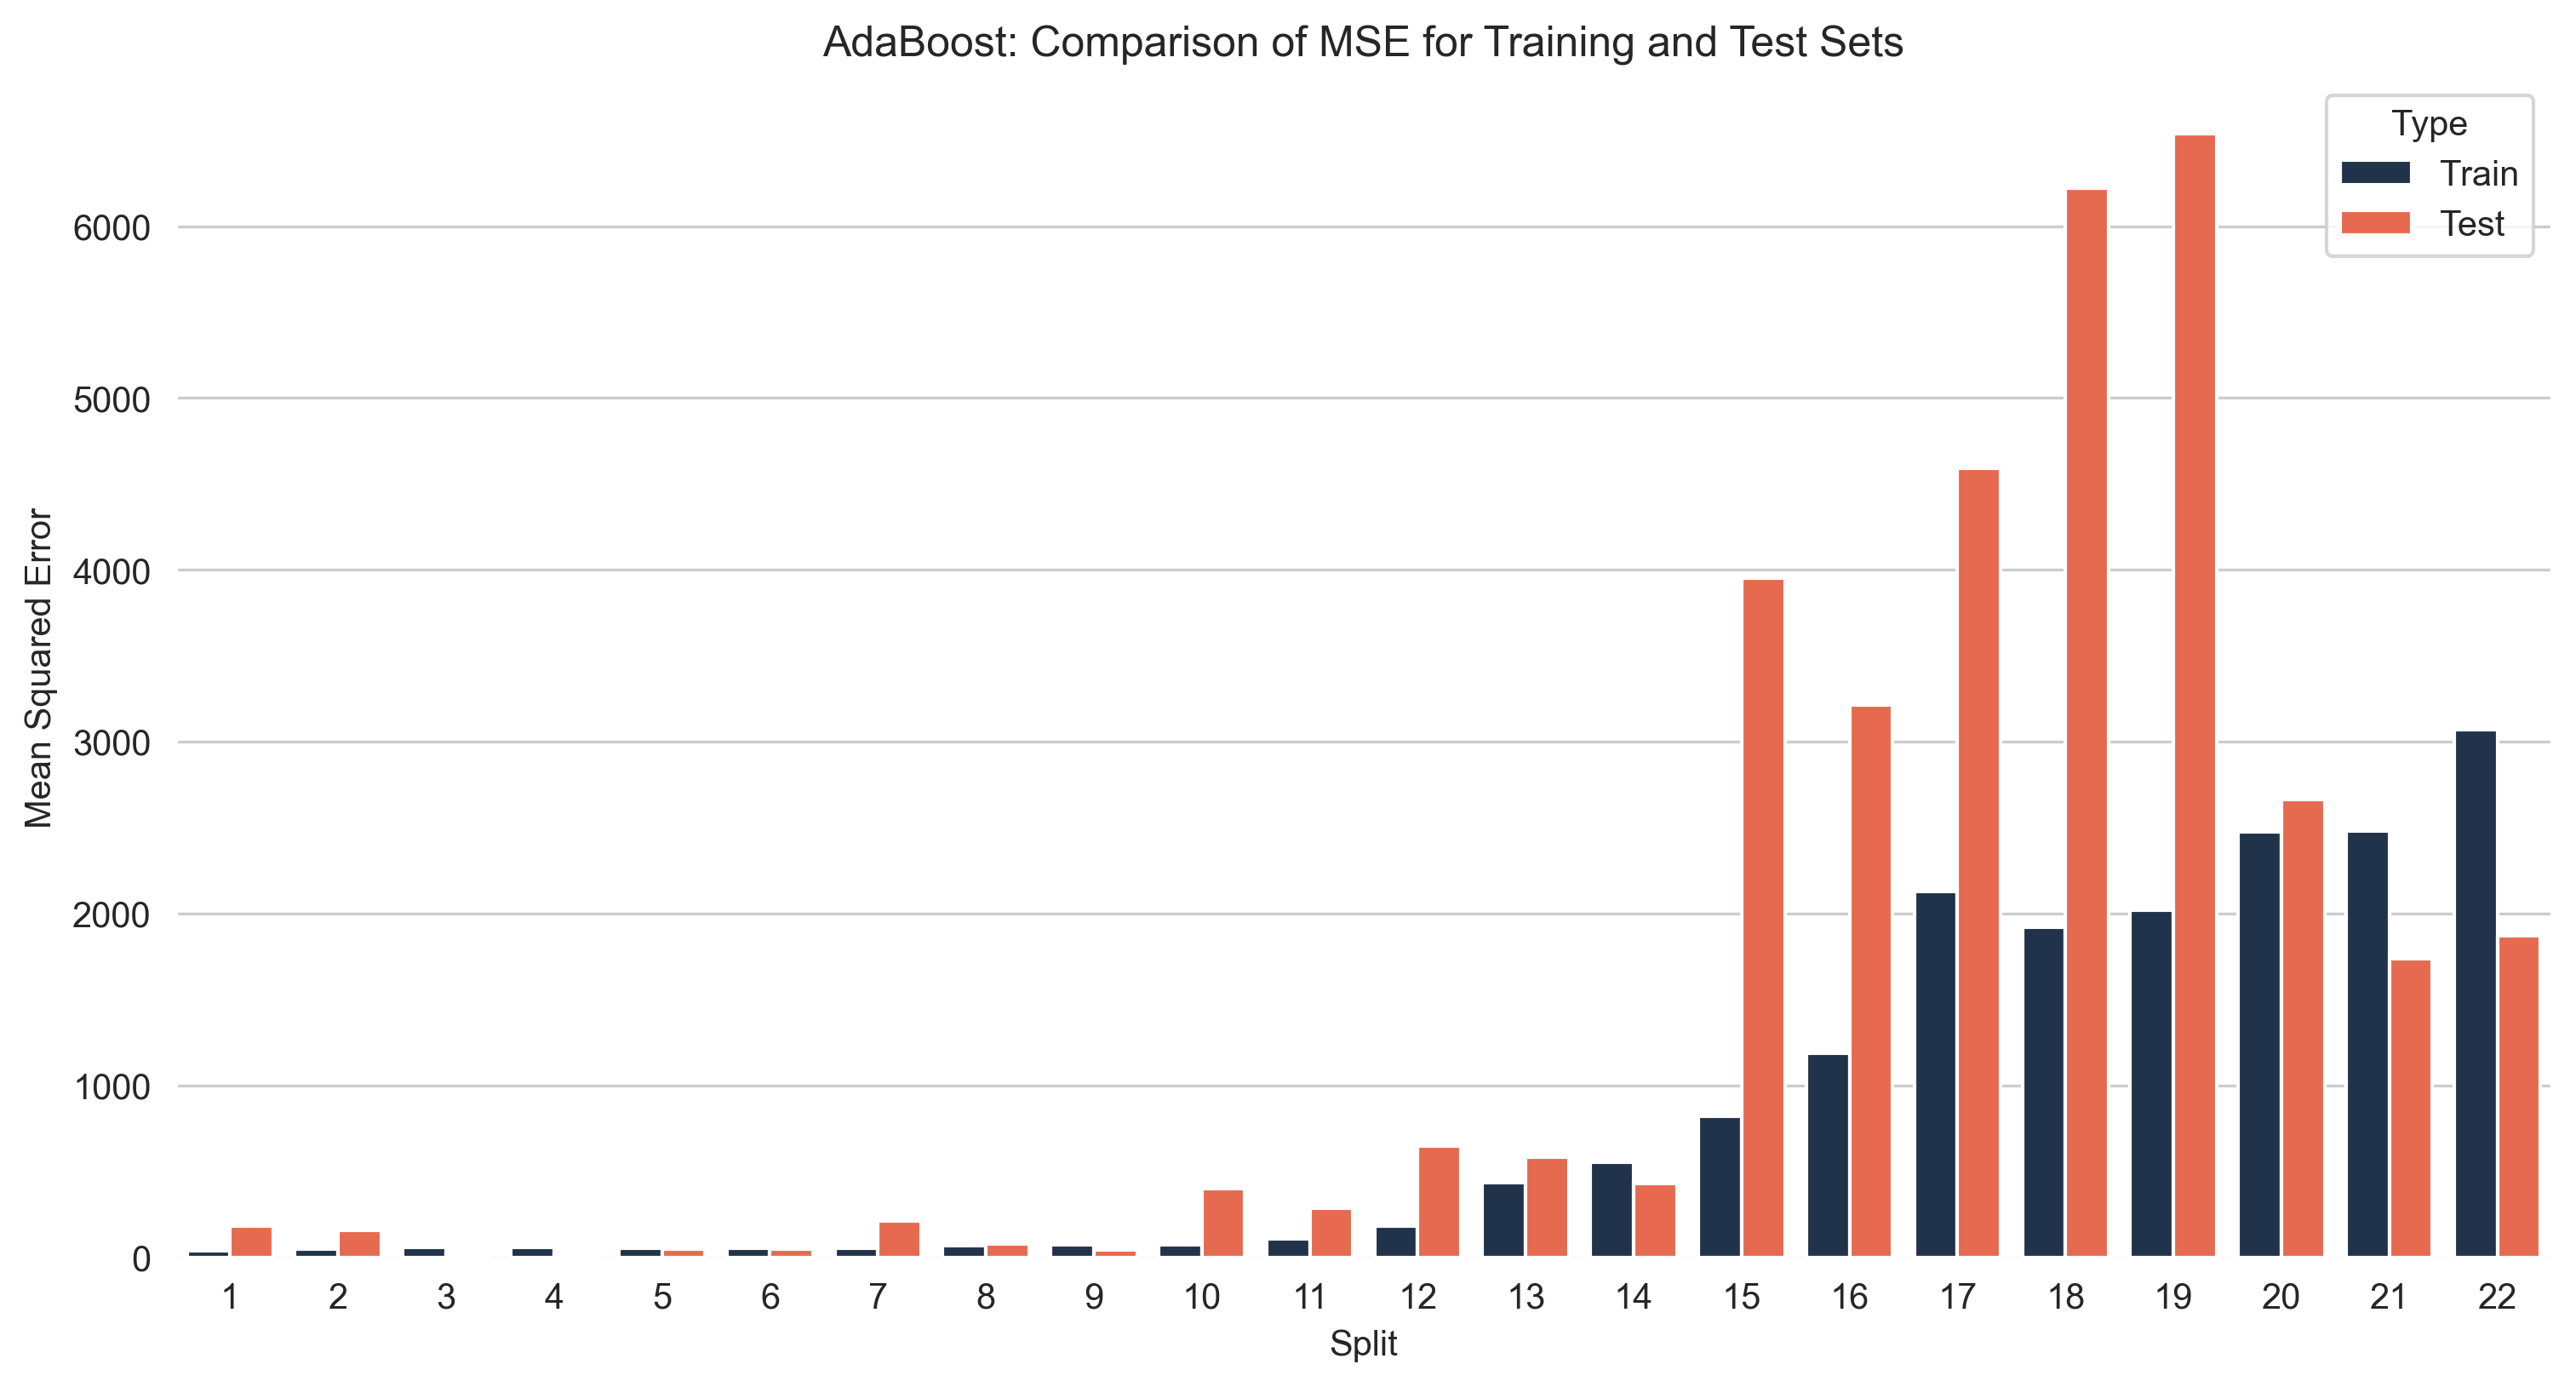

In [20]:
from sklearn.ensemble import AdaBoostRegressor

ADA_mse_scores, ADA_average_mse, ADA_mse_score_sum, ADA_plot_data = evaluate_time_series_model(X, y, AdaBoostRegressor, model_params={'loss':'square'})
plot_time_series(ADA_plot_data, ADA_mse_score_sum, model_name='AdaBoost')

---

#### ExtraTreesRegressor

Split 1:
MSE (train): 6.127165129526988e-27, MSE (test): 163.32228871833334
Split 2:
MSE (train): 4.998299395046757e-27, MSE (test): 12.0498548434722
Split 3:
MSE (train): 4.3354436603926646e-27, MSE (test): 13.906529385694444
Split 4:
MSE (train): 3.989757508886845e-27, MSE (test): 10.480356517500011
Split 5:
MSE (train): 3.782963701133553e-27, MSE (test): 62.411083254305545
Split 6:
MSE (train): 3.450982978371276e-27, MSE (test): 9.7036637213889
Split 7:
MSE (train): 3.1264784035890147e-27, MSE (test): 318.7429083194446
Split 8:
MSE (train): 3.126448496263953e-27, MSE (test): 57.219367312083335
Split 9:
MSE (train): 3.1487957897043756e-27, MSE (test): 48.02864671208328
Split 10:
MSE (train): 3.352295897204877e-27, MSE (test): 162.49840705152775
Split 11:
MSE (train): 3.833943994833066e-27, MSE (test): 83.01395808597242
Split 12:
MSE (train): 5.143635856919807e-27, MSE (test): 830.7774440672224
Split 13:
MSE (train): 1.0497143591820517e-26, MSE (test): 1413.6291224859724
Split 14:
MSE

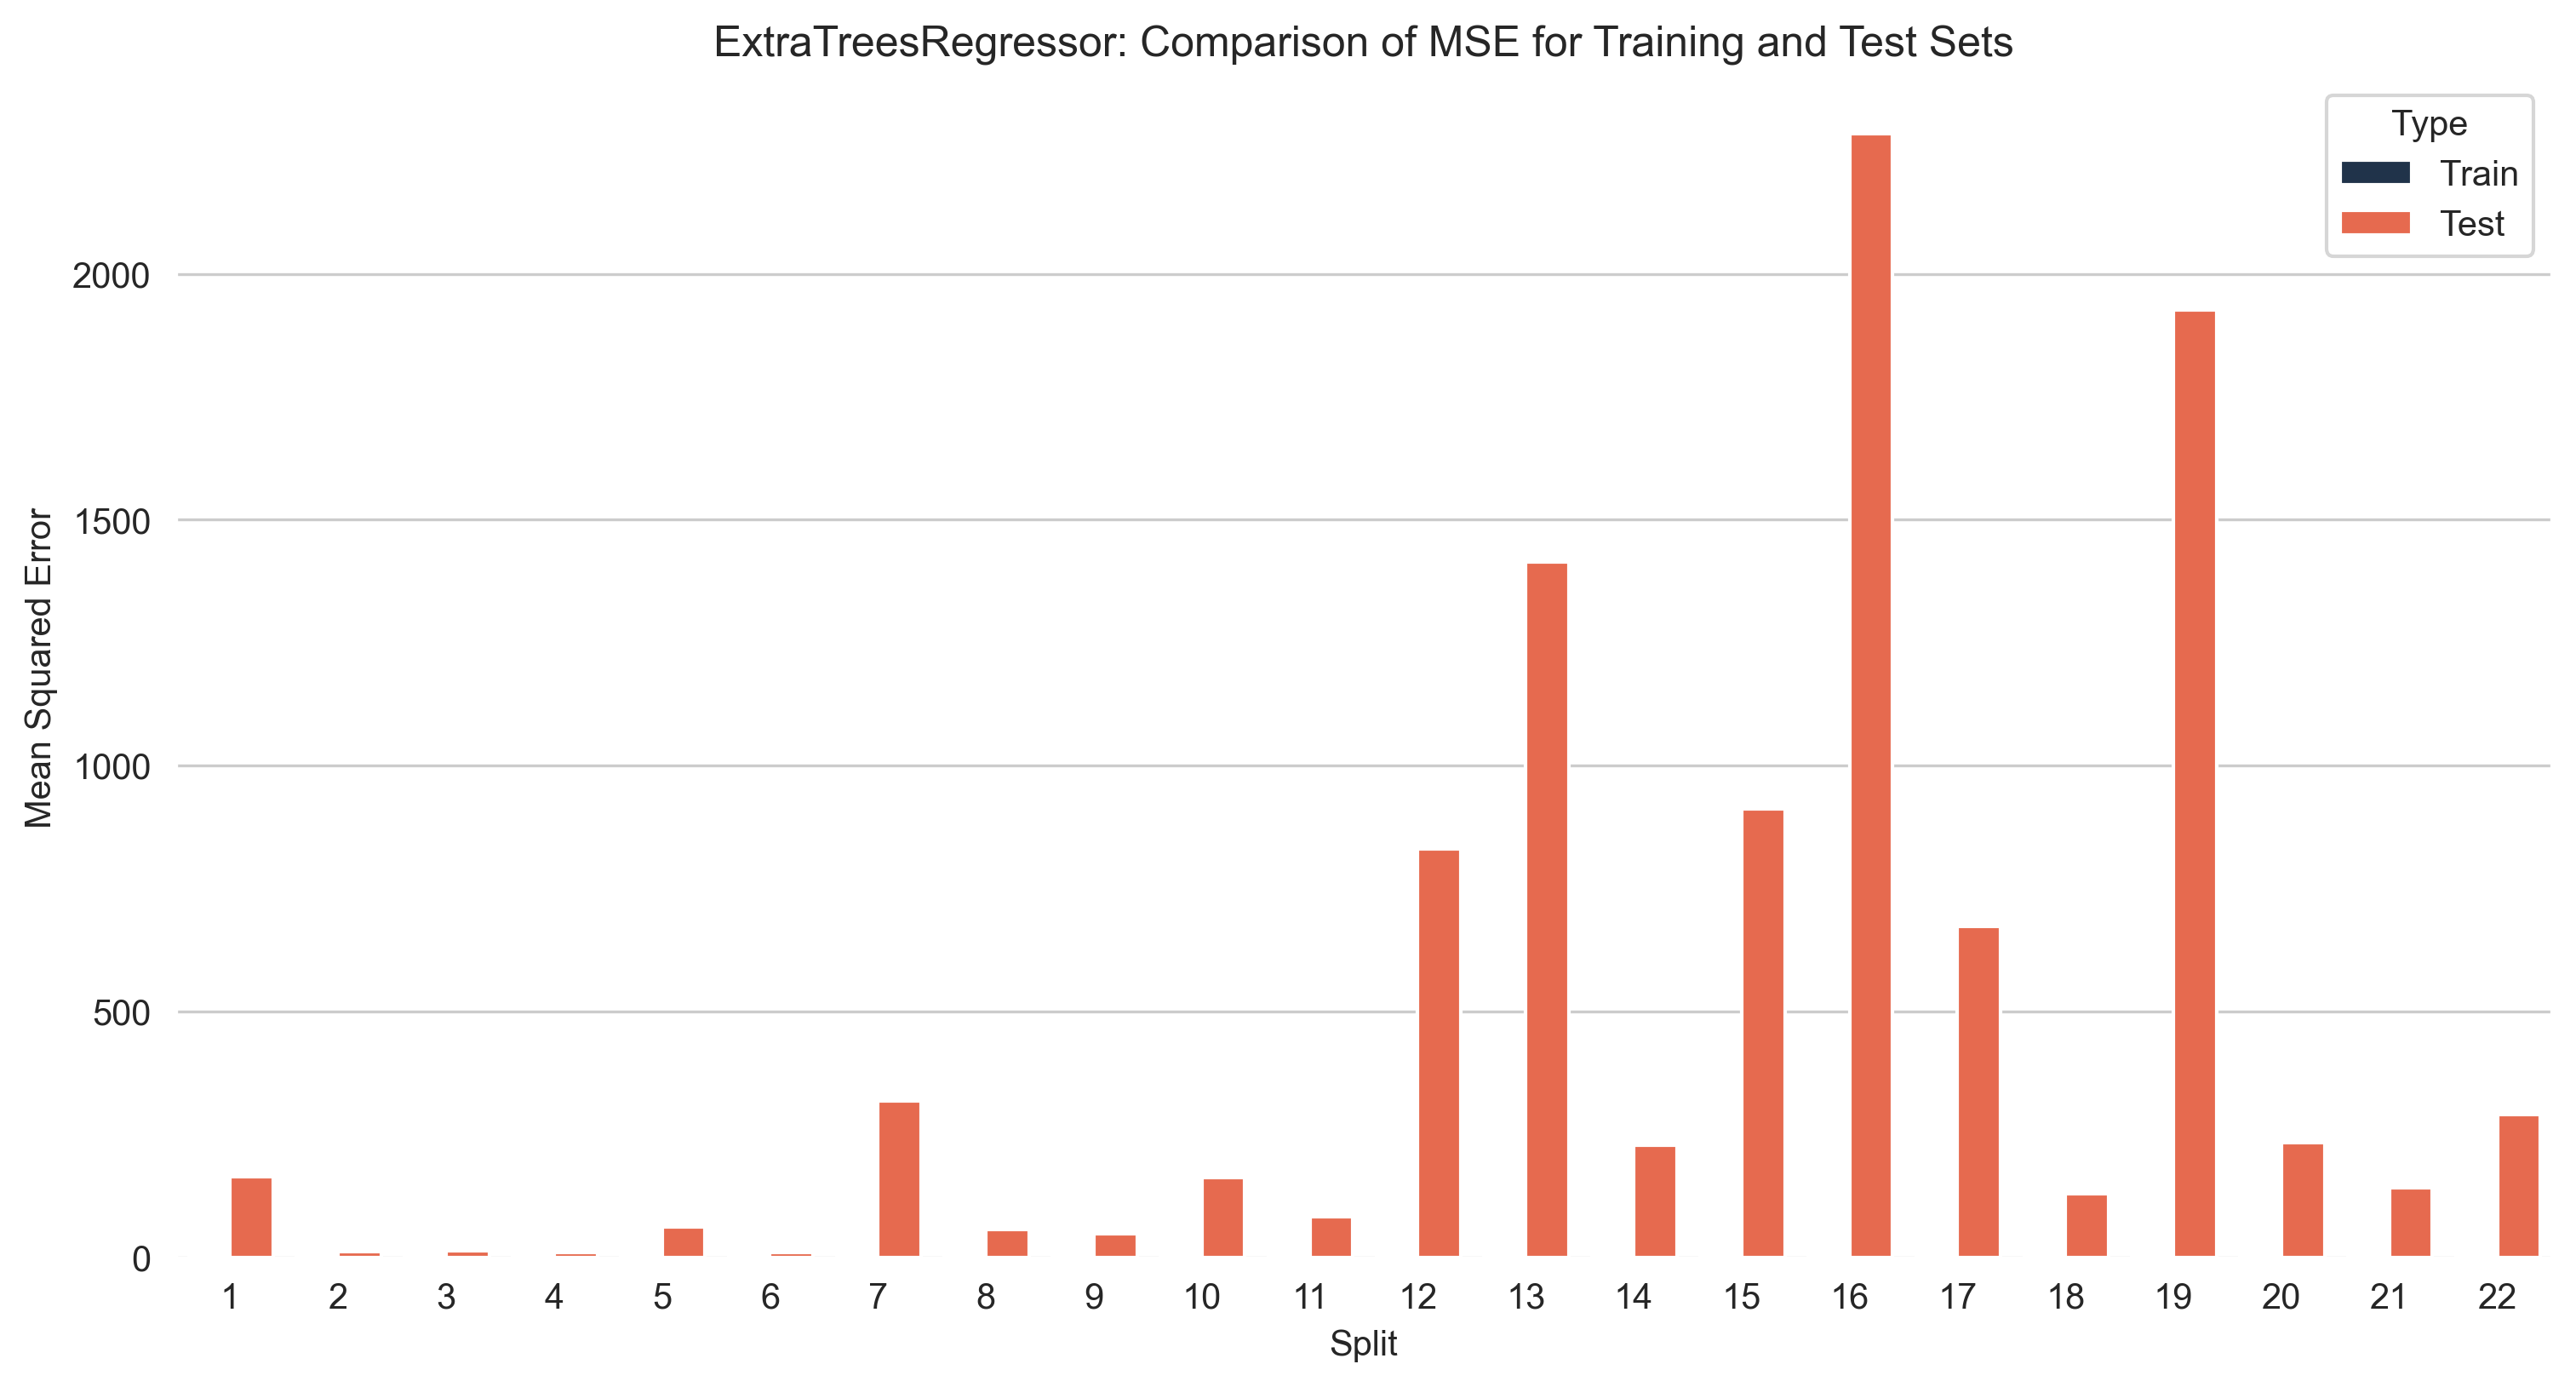

In [26]:
from sklearn.ensemble import ExtraTreesRegressor

ETR_mse_scores, ETR_average_mse, ETR_mse_score_sum, ETR_plot_data = evaluate_time_series_model(X, y, ExtraTreesRegressor)
plot_time_series(ETR_plot_data, ETR_mse_score_sum, model_name='ExtraTreesRegressor', only_bar=True)

---
#### StackingRegressor

Split 1:
MSE (train): 20.477475810890407, MSE (test): 200.23215930083336
Split 2:
MSE (train): 23.37290737539268, MSE (test): 12.198143308888875
Split 3:
MSE (train): 14.543773475435307, MSE (test): 16.201293541388893
Split 4:
MSE (train): 13.934921171228304, MSE (test): 15.953775445694456
Split 5:
MSE (train): 19.650706986792684, MSE (test): 54.13979171124999
Split 6:
MSE (train): 21.959498565982482, MSE (test): 26.342351054583293
Split 7:
MSE (train): 37.536945902046966, MSE (test): 771.00319578639
Split 8:
MSE (train): 42.9080565702494, MSE (test): 107.08924816791668
Split 9:
MSE (train): 44.90857176147383, MSE (test): 39.12537463124998
Split 10:
MSE (train): 38.22390724735523, MSE (test): 174.5324303530556
Split 11:
MSE (train): 64.81113335908215, MSE (test): 368.6889442663882
Split 12:
MSE (train): 257.59320131862273, MSE (test): 3537.197337003475
Split 13:
MSE (train): 1460.0920868678327, MSE (test): 1816.0857521491669
Split 14:
MSE (train): 1726.2668704232879, MSE (test): 7020.4

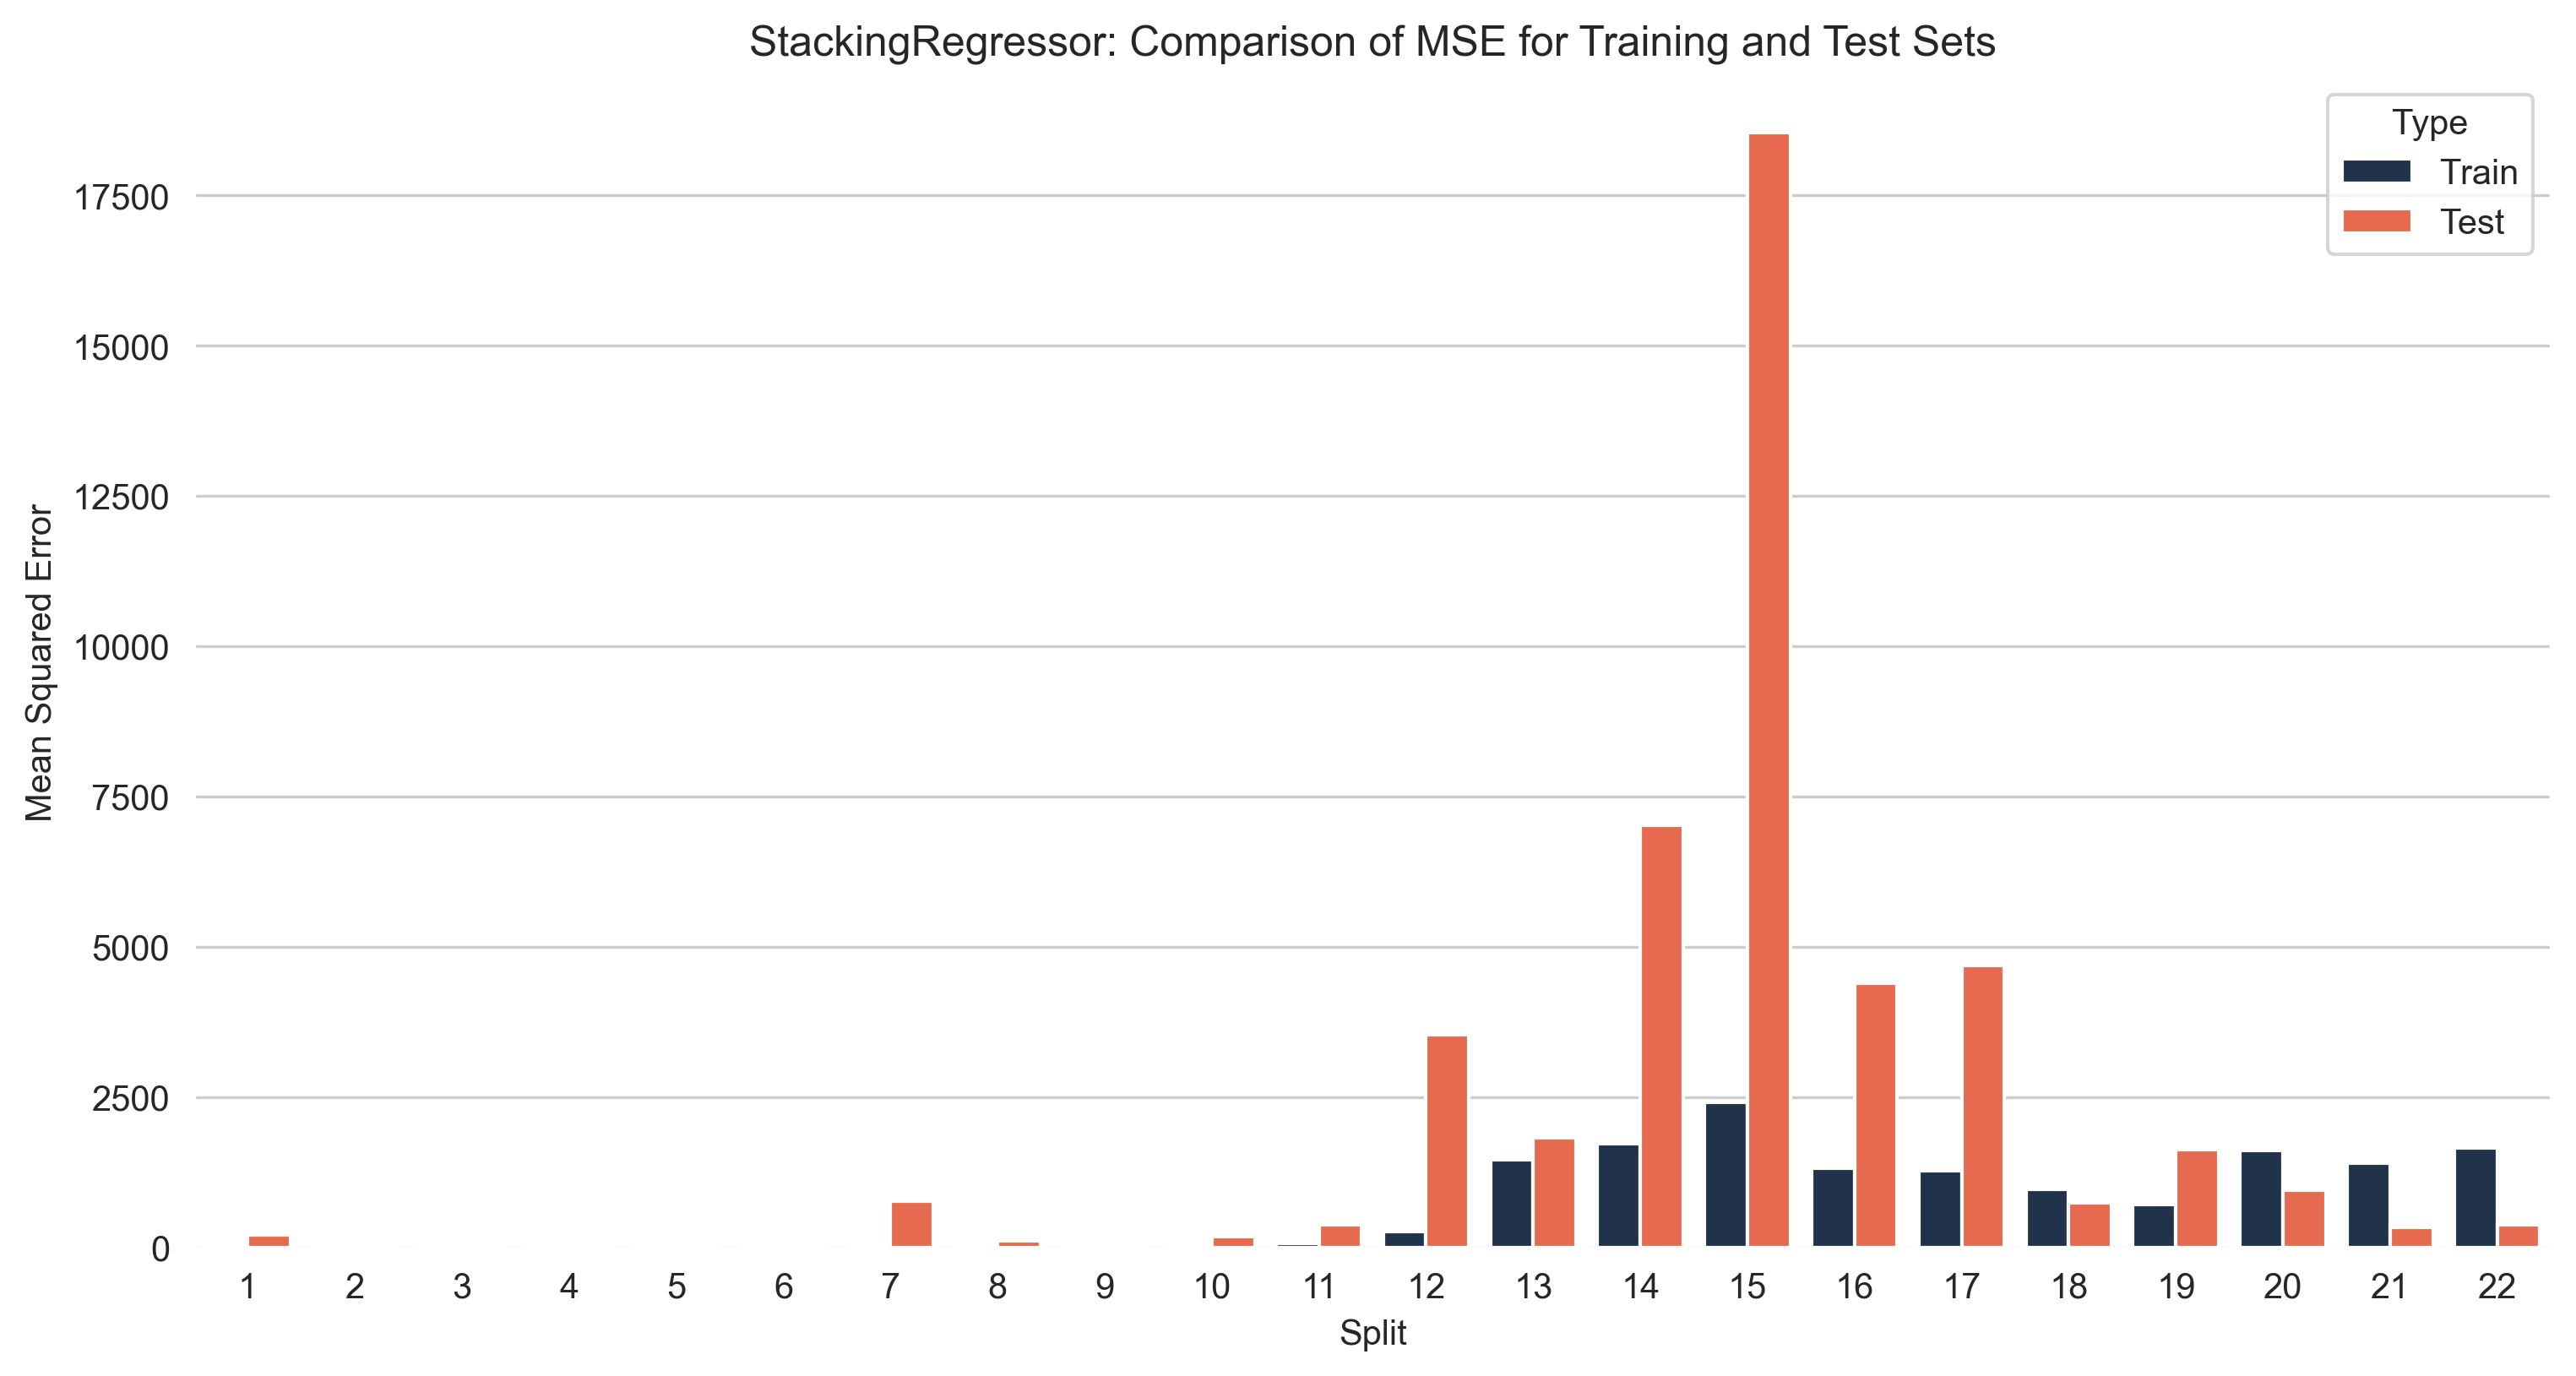

In [22]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR

estimators = [
    ('lr', RidgeCV()),
    ('svr', LinearSVR(random_state=42)),
    ('etr', ExtraTreesRegressor())
]

STR_mse_scores, STR_average_mse, STR_mse_score_sum, STR_plot_data = evaluate_time_series_model(X, y, StackingRegressor, model_params={'estimators':estimators, 'final_estimator':ExtraTreesRegressor()})
plot_time_series(STR_plot_data, STR_mse_score_sum, model_name='StackingRegressor')

---
#### ARIMA

/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_predic

Split 1:
MSE (train): 34.95043745082632, MSE (test): 2392.042079779276


/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided 

Split 2:
MSE (train): 29.25471011979829, MSE (test): 182.1320309708093


/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided 

Split 3:
MSE (train): 26.22321611232004, MSE (test): 88.17523897012555


/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided 

Split 4:
MSE (train): 23.623796317078373, MSE (test): 122.94543593322825


/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided 

Split 5:
MSE (train): 22.532021245999058, MSE (test): 170.71296466898252


/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided 

Split 6:
MSE (train): 21.848905074613793, MSE (test): 39.23361496668302


/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided 

Split 7:
MSE (train): 21.80715205097032, MSE (test): 230.7322832628153


/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided 

Split 8:
MSE (train): 24.748270766217324, MSE (test): 335.50803833840484


/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided 

Split 9:
MSE (train): 24.95545746287413, MSE (test): 76.16841477423357


/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided 

Split 10:
MSE (train): 25.70698862163837, MSE (test): 865.5443111984971


/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided 

Split 11:
MSE (train): 27.89922816075688, MSE (test): 181.37873401610676


/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided 

Split 12:
MSE (train): 32.379866990532804, MSE (test): 5135.318072197198


/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided 

Split 13:
MSE (train): 66.18865230433484, MSE (test): 2316.414135493359


/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided 

Split 14:
MSE (train): 97.40030939117334, MSE (test): 3309.00743367036


/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided 

Split 15:
MSE (train): 115.20296285104551, MSE (test): 10320.23498375469


/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided 

Split 16:
MSE (train): 181.4826845503213, MSE (test): 22512.07333124539


/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided 

Split 17:
MSE (train): 206.70373388197822, MSE (test): 11418.917336237177


/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided 

Split 18:
MSE (train): 202.22969125891785, MSE (test): 3026.3178706951608


/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided 

Split 19:
MSE (train): 198.3069518928892, MSE (test): 7538.010343660319


/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided 

Split 20:
MSE (train): 208.25673433480281, MSE (test): 5302.41384280982


/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided 

Split 21:
MSE (train): 205.46582504676198, MSE (test): 1237.4839754961745


/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/paco/Desktop/neuefische/capstone_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Split 22:
MSE (train): 198.88036152971395, MSE (test): 1345.14548075357
Average Test MSE across all splits: 3552.086816040562


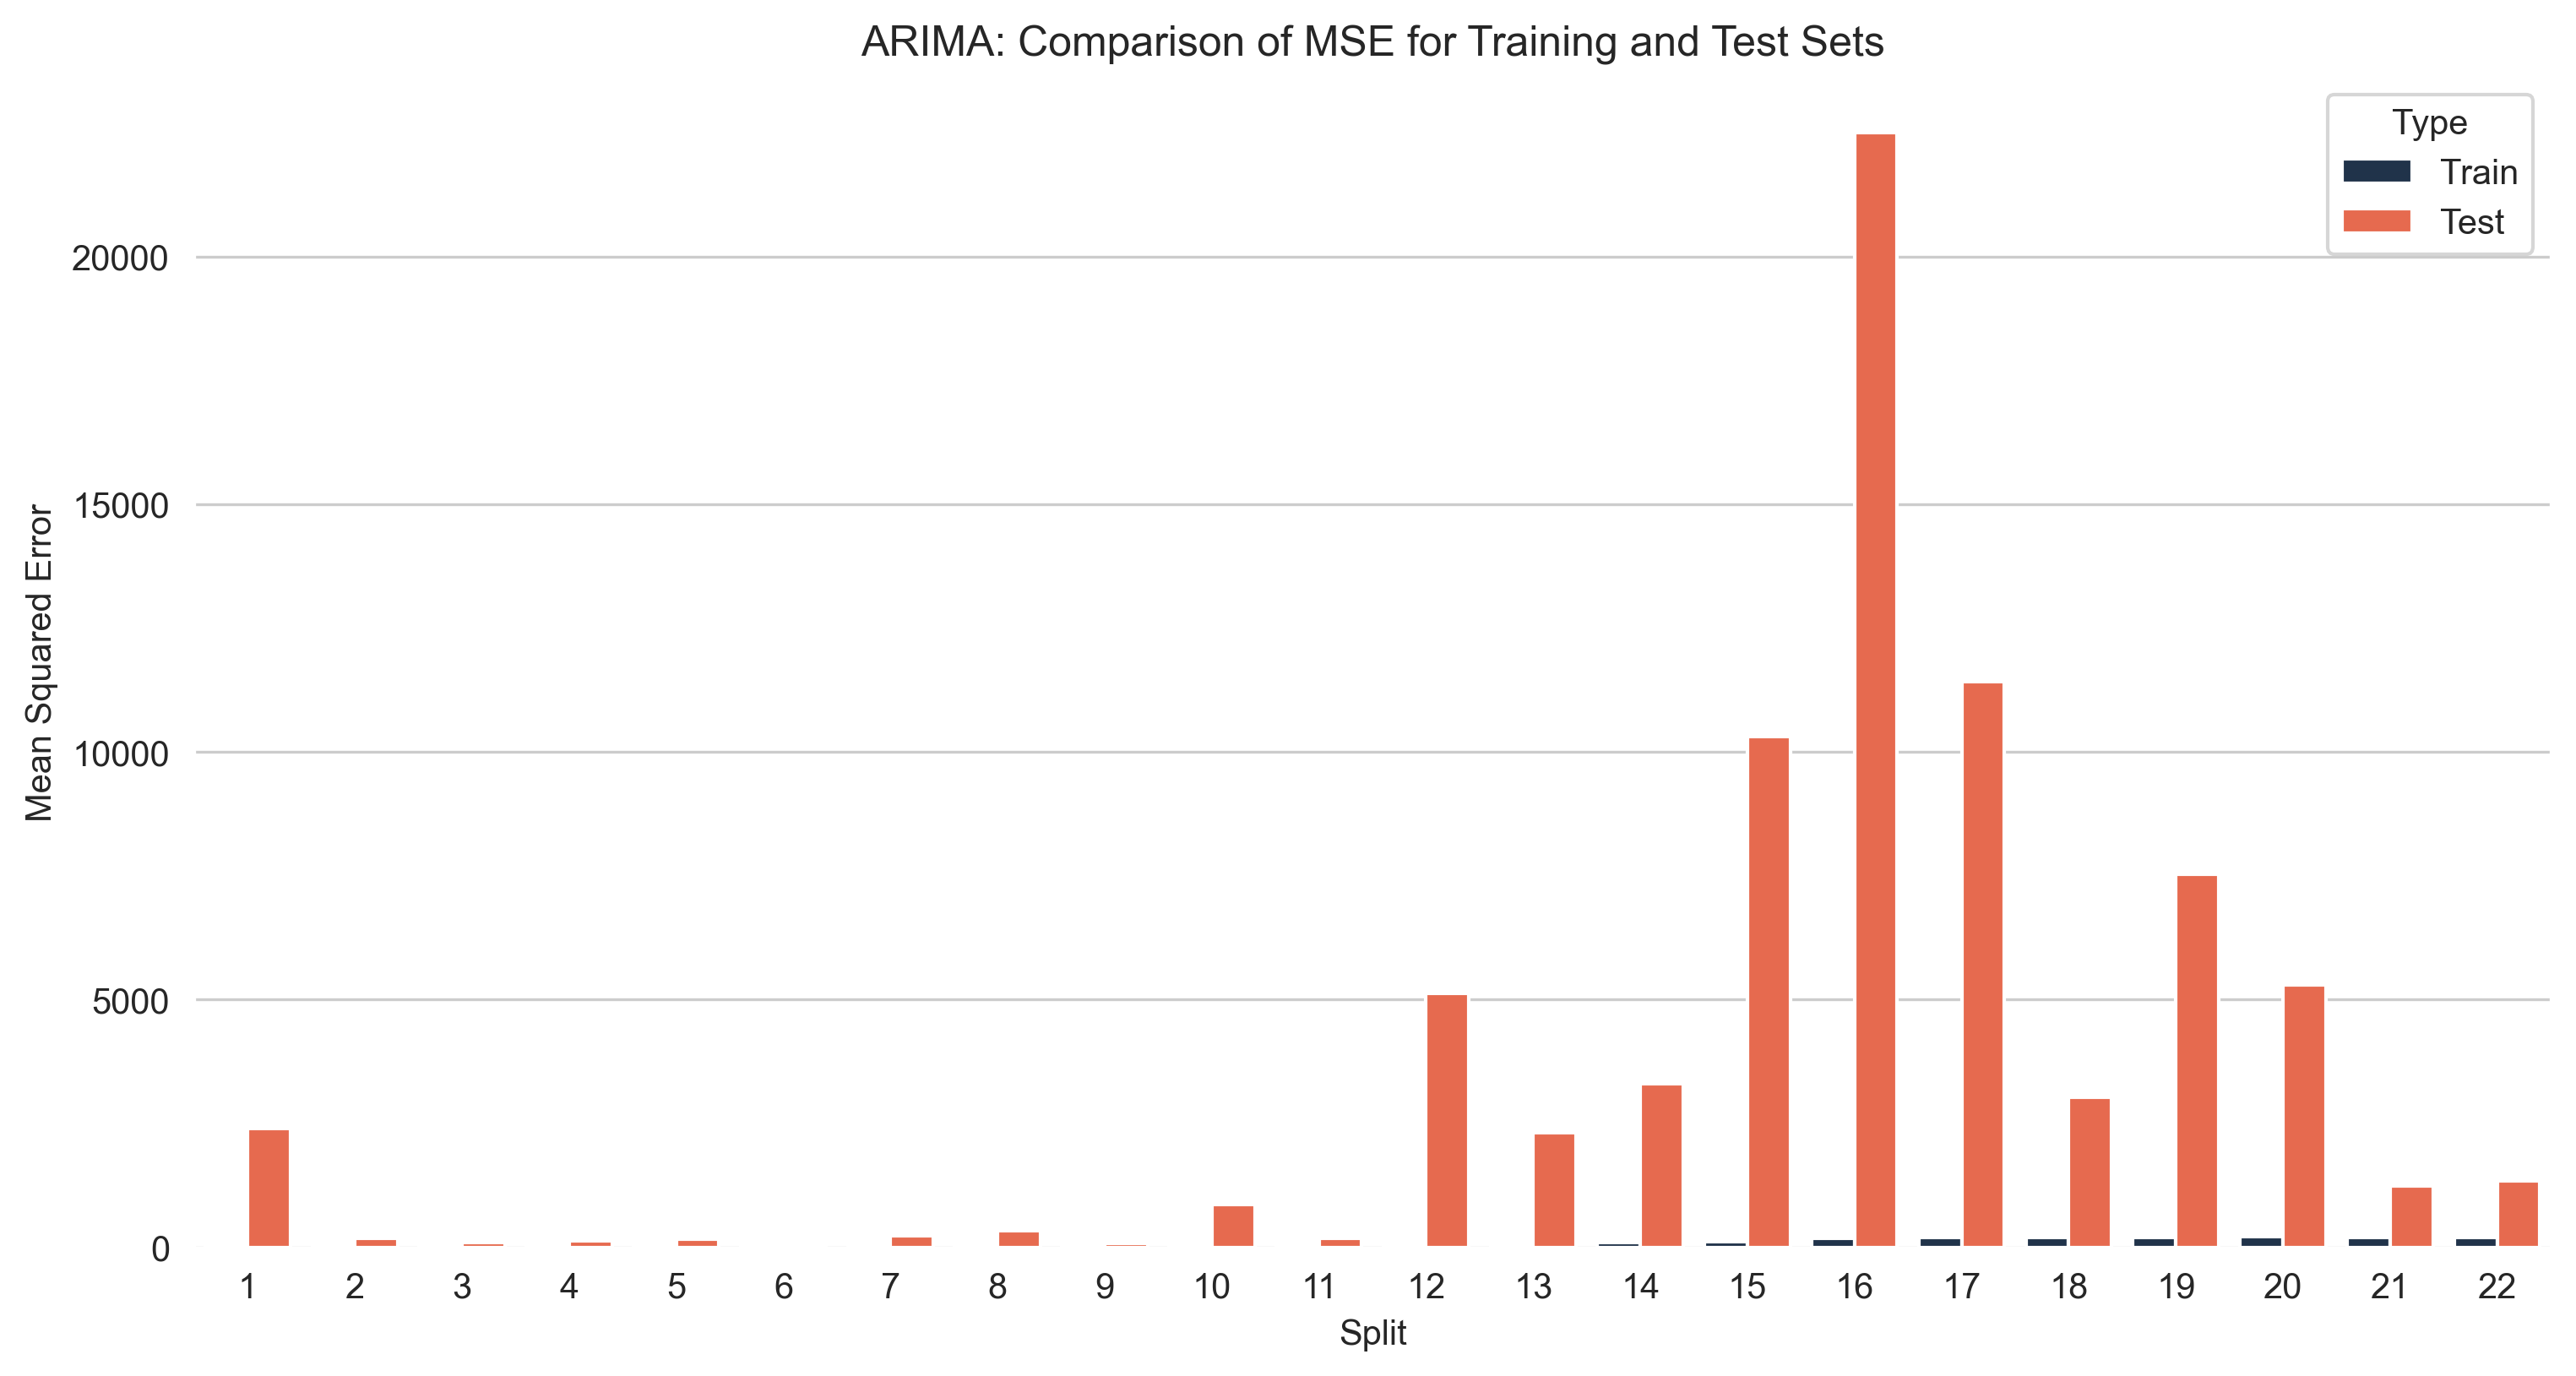

In [24]:
from statsmodels.tsa.arima.model import ARIMA

ARIMA_mse_scores, ARIMA_average_mse, ARIMA_mse_score_sum, ARIMA_plot_data = evaluate_time_series_model(X, y, ARIMA, model_params={'order':(5,1,0)})
plot_time_series(ARIMA_plot_data, ARIMA_mse_score_sum, model_name='ARIMA')